In [1]:
setwd('../Thyroid_code')
source('Tumor_analysis_functions.R')
library(Seurat)
library(ggsci)
library(dplyr)
library(ggplot2)
library(reshape2)
library(cowplot)
library(ggpubr)
library(glue)
library(vegan)
library(ComplexHeatmap)
library(ggrepel)
#library(GeneTrajectory)
#require(plot3D)
#library(scatterplot3d)
process_seurat_noIG <-function(obj, dim=30, n.components=2,resolution=0.5,npcs=50){
  obj <- NormalizeData(obj, normalization.method = "LogNormalize", scale.factor = 10000)
  obj <- FindVariableFeatures(obj, selection.method = "vst", nfeatures = 2000)
  vf_gene = VariableFeatures(obj)
  #vf_gene = grep('^IG', vf_gene,value = T, invert = T)
  obj <- ScaleData(obj, features = vf_gene)
  obj <- RunPCA(obj, features = vf_gene, npcs = npcs, verbose = TRUE)
  obj = RunHarmony(obj, "patient", plot_convergence = TRUE)
  obj <- FindNeighbors(obj, reduction = "harmony",dims = 1:dim)
  obj <- FindClusters(obj, resolution = resolution)
  obj <- RunUMAP(obj,dims = 1:dim,reduction = "harmony", n.components=n.components)
  return(obj)
}
source('../color_definition.R')
output_dir='./Figure6/'


Warning message:
“package ‘Seurat’ was built under R version 4.2.3”
Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘harmony’ was built under R version 4.2.3”
Loading required package: Rcpp

Warning message:
“package ‘Rcpp’ was built under R version 4.2.3”
Warning message:
“package ‘reshape2’ was built under R version 4.2.3”

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend


Warning message:
“package ‘glue’ was built un

# 基因轨迹

In [3]:
write.table(srt_B@meta.data, '../output/MB_B_meta.txt', sep='\t', quote=F, row.names=T, col.names=T)

In [2]:
# ---------------------------基因轨迹-------------------------------------------
#### Gene trajectory ####
mal_B = c('TC028_T3_1', 'TC045_B_2', 'TC047_B_2')
srt_B = readRDS('../output/MB_B.rds')
# srt_B = process_seurat_noIG(srt_B, dim=10,npcs=50)
srt_B[['Type']] = 'NB'
srt_B@meta.data[srt_B$malignant_tendencies=='Yes', 'Type'] = 'EICs'


In [3]:

assay <- "RNA"
DefaultAssay(srt_B) <- assay
srt_B <- FindVariableFeatures(srt_B, nfeatures = 500)
all_genes <- srt_B@assays[[assay]]@var.features
srt_B <- GeneTrajectory::RunDM(srt_B,reduction = "pca",dims=1:10, K = 3)
DimPlot(srt_B, reduction = 'dm', group.by = 'malignant_tendencies')


ERROR: Error in loadNamespace(x): there is no package called ‘GeneTrajectory’


In [38]:
cell.graph.dist <- GetGraphDistance(srt_B, K = 10)
cg_output <- CoarseGrain(srt_B, cell.graph.dist, all_genes, N = 500)
if(!reticulate::virtualenv_exists('gene_trajectory')){
  reticulate::virtualenv_create('gene_trajectory', packages=c('gene_trajectory'))
}
reticulate::use_virtualenv('gene_trajectory')
cal_ot_mat_from_numpy <- reticulate::import('gene_trajectory.compute_gene_distance_cmd')$cal_ot_mat_from_numpy
gene.dist.mat <- cal_ot_mat_from_numpy(ot_cost = cg_output[["graph.dist"]], gene_expr = cg_output[["gene.expression"]], num_iter_max = 50000, show_progress_bar = TRUE)
rownames(gene.dist.mat) <- cg_output[["features"]]
colnames(gene.dist.mat) <- cg_output[["features"]]
dim(gene.dist.mat)

gene_embedding <- GetGeneEmbedding(gene.dist.mat, K = 5)$diffu.emb
# Extract 3 gene trajectories
gene_trajectory <- ExtractGeneTrajectory(gene_embedding, gene.dist.mat, N = 3, t.list = c(4,9,7), K = 5)
table(gene_trajectory$selected)
g1 = rownames(gene_trajectory[which.max(gene_trajectory$Pseudoorder1),])
g2 = rownames(gene_trajectory[which.max(gene_trajectory$Pseudoorder2),])
g3 = rownames(gene_trajectory[which.max(gene_trajectory$Pseudoorder3),])


Constructing kNN graph

Constructing graph distance matrix

The largest graph distance is 95

Run k-means clustering

Coarse-grain matrices



Using Python: /usr/local/Cellar/python@3.9/3.9.7_1/Frameworks/Python.framework/Versions/3.9/bin/python3.9
Creating virtual environment 'gene_trajectory' ... 


+ '/usr/local/Cellar/python@3.9/3.9.7_1/Frameworks/Python.framework/Versions/3.9/bin/python3.9' -m venv /Users/server2/.virtualenvs/gene_trajectory



Done!
Installing packages: pip, wheel, setuptools


+ /Users/server2/.virtualenvs/gene_trajectory/bin/python -m pip install --upgrade pip wheel setuptools



Installing packages: gene_trajectory


+ /Users/server2/.virtualenvs/gene_trajectory/bin/python -m pip install --upgrade --no-user gene_trajectory



Virtual environment 'gene_trajectory' successfully created.


[1] 500 500

FGF7

NRN1L

ACTC1




Trajectory-1 Trajectory-2 Trajectory-3 
          33           85          382 

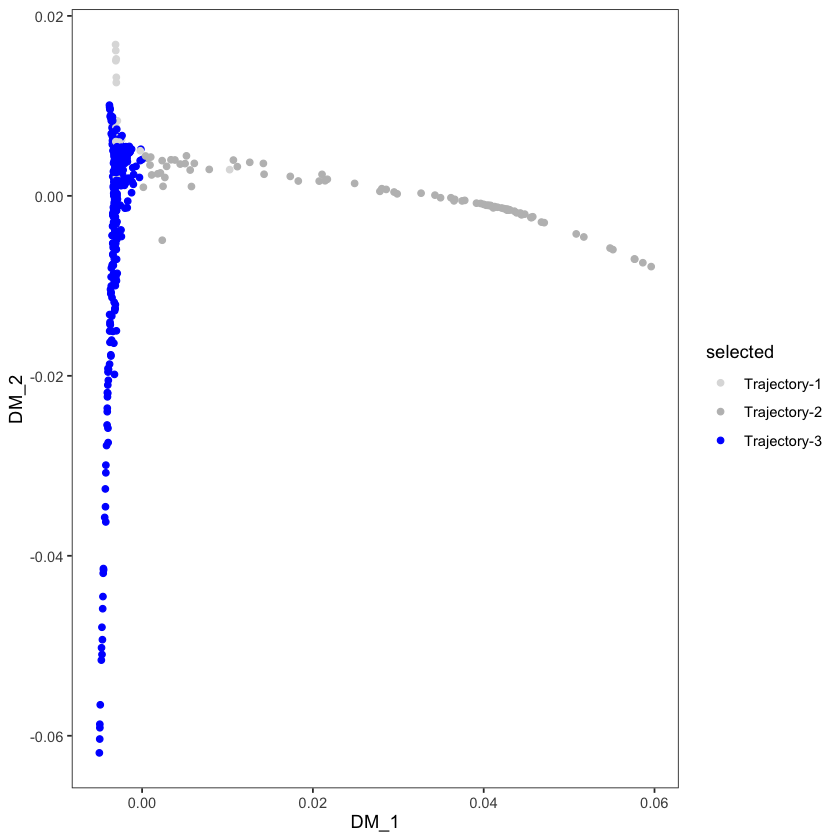

In [39]:

gene_trajectory %>%
  ggplot(aes(x=DM_1, y=DM_2,color=selected))+
  geom_point()+
  scale_color_manual(values = c('Trajectory-1'='#dddddd','Trajectory-2'='gray','Trajectory-3'='blue'))+
  theme_bw()+
  theme(panel.grid = element_blank())


In [40]:

label_data = gene_trajectory[c('NPC2','ZCCHC12','CLDN1', g1, g2, g3),]
label_data$gene=rownames(label_data)

dev.off()
pdf(glue('{output_dir}/基因轨迹.pdf'),width = 8,height = 8)
traj_col = c('Trajectory-1'='#dddddd','Trajectory-2'='gray','Trajectory-3'='blue')#pal_npg()(3)
names(traj_col) = sort(unique(gene_trajectory$selected))

pseudo = log2(gene_trajectory$Pseudoorder3+1)
min(pseudo[pseudo>0])
col_func = circlize::colorRamp2(c(6, 7.5, 8, 8.5),c('#2C7BB6','#ABD9E9','#FDAE61','#D7191C'))
traj_col = col_func(pseudo)
traj_col[pseudo==0] = 'gray'
s3d=scatterplot3d(gene_trajectory[,c(1,2,3)],color = traj_col, pch = 16, cex.symbols=1)

dev.off()


null device 
          1

[1] 1

pdf 
  2

# bin连续变化

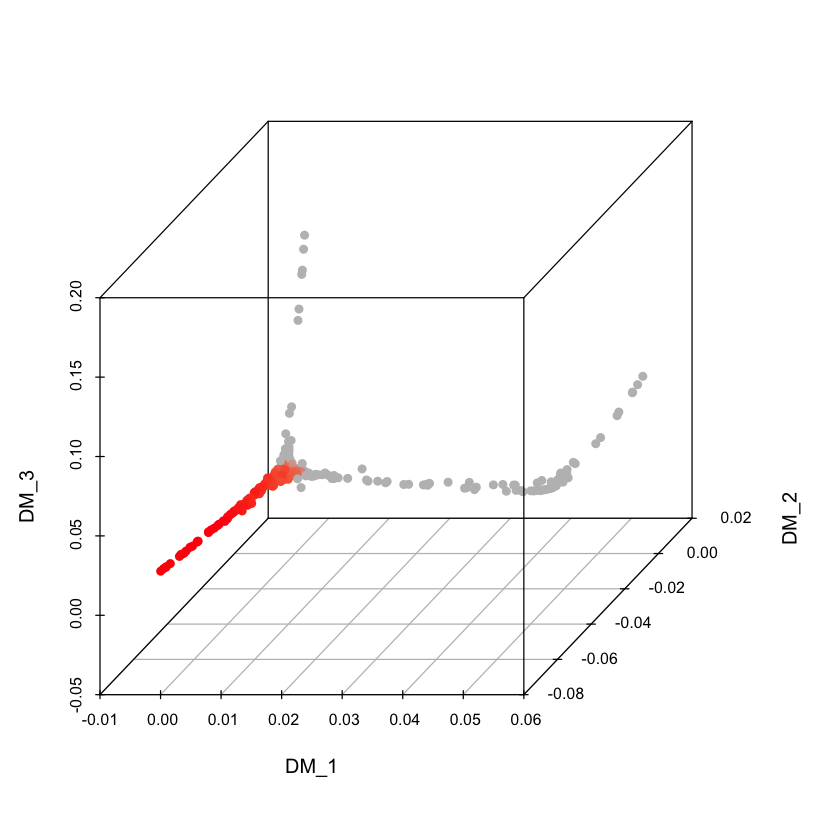

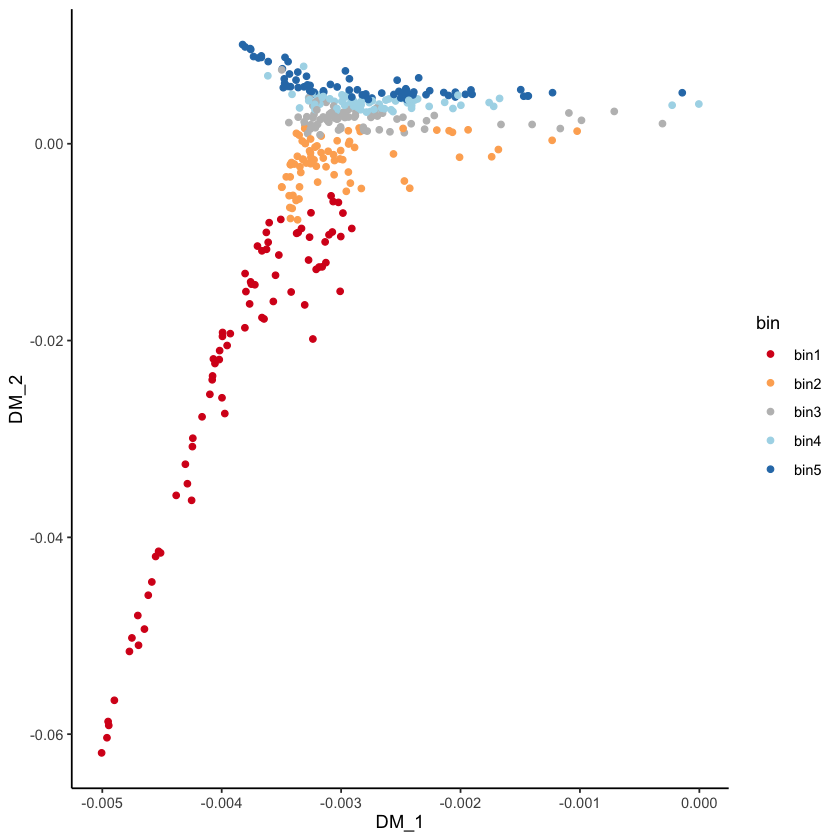

In [41]:
#### Continuous bin changes ###
t3 = gene_trajectory[gene_trajectory$selected=='Trajectory-3',]
colf = circlize::colorRamp2(c(0, max(gene_trajectory$Pseudoorder3)), colors = c('gray','red'))
s3d=scatterplot3d(gene_trajectory[,1:3],color = colf(gene_trajectory$Pseudoorder3), pch = 16, cex.symbols=1)
genes = rownames(t3[order(t3$Pseudoorder3, decreasing = T),])

traj_gene = t3[order(t3$Pseudoorder3, decreasing = T),]

step <- nrow(t3)/5
gene_bin = c()
for (i in 1:5) {
  start <- ceiling((i - 1) * step + 1)
  end <- min(ceiling(i * step), length(genes))
  genes.subset <- genes[start:end]
  gene_bin = rbind(gene_bin, data.frame(bin=paste0('bin',i), genes=genes.subset))
}
t3[gene_bin$genes, 'bin'] = gene_bin$bin
a=ggplot(t3, aes(x=DM_1, y=DM_2))+
  geom_point(aes(color=bin))+
  #geom_text_repel(data=label_data2,mapping = aes(label=gene),nudge_y=-0.002, nudge_x = -0.001)+
  scale_color_manual(values = rev(c('#2C7BB6','#ABD9E9','gray','#FDAE61','#D7191C')))+
  theme_classic()
a
ggsave(glue('{output_dir}/基因轨迹(轨迹3).pdf'), a,
       width=100, height=80, units='mm', dpi = 450, bg = 'transparent')


Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


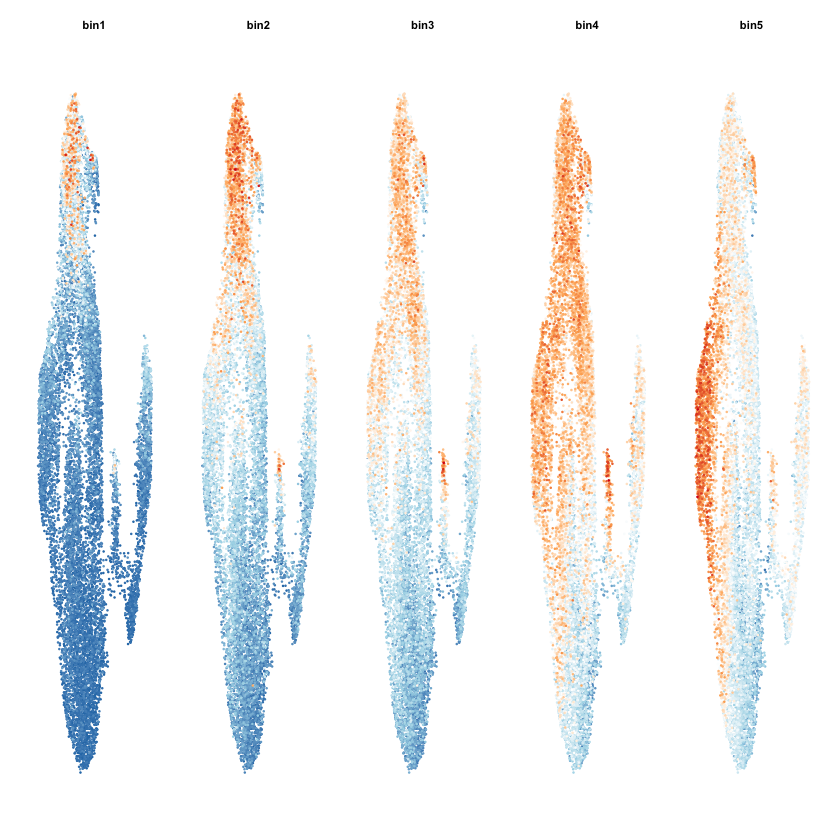

In [42]:

data_S <- AddGeneBinScore(srt_B, gene_trajectory, N.bin = 5, trajectories = 1:3, assay = "RNA", reverse = c(F, F, T))

a=FeaturePlot(data_S, pt.size = 0.05, features = paste0("Trajectory",3,"_genes", 1:5), ncol = 5, order = T) &
  scale_color_gradientn(colors = c('#2C7BB6','#ABD9E9','#FFFFFF','#FDAE61','#D7191C')) & 
  NoLegend() & 
  NoAxes() & 
  theme(title = element_text(size = 6))

for(i in 1:5){
  a[[i]]  = a[[i]]+labs(title=paste0('bin',i))
}
a

ggsave(glue('{output_dir}//基因轨迹_轨迹3_bin.pdf'), a,
       width=200, height=50, units='mm', dpi = 450, bg = 'transparent')


# 轨迹基因富集 

In [ ]:

#### Trajectory gene enrichment###
hallmark_data = GSEABase::getGmt('../h.all.v7.4.symbols.gmt')
hallmark_data = hallmark_data@.Data
hallmark_list = list()
for(i in hallmark_data){
  hallmark_list[[i@setName]] = i@geneIds
}
gene_bin2 = gene_bin
gene_bin2$cluster = gene_bin$bin
gene_bin2$avg_log2FC=1
gene_bin2$gene = gene_bin2$genes
res = enrich_with_marker(gene_bin2, hallmark_list,topn=100)


In [44]:

library(fgsea)
library(clusterProfiler)
library(GOSemSim)
library(DOSE)
library(AnnotationDbi)
library(GO.db)




clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter


GOSemSim v2.28.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use GOSemSim in published research, please cite:
- Guangchuang Yu. Gene Ontology Semantic Similarity Analysis Using GOSemSim. In: Kidder B. (eds) Stem Cell Transcriptional Networks. Methods in Molecular Biology, 2020, 2117:207-215. Humana, New York, NY. doi:10.1007/978-1-0716-0301-7_11
- Guangchuang Yu, Fei Li, Yide Qin, Xiaochen Bo, Yibo Wu, Shengqi Wang. GOSemSim: an R package for measuring semantic similarity among GO terms

In [ ]:
get_GO<-function (OrgDb, ont, keytype) {
  GO_Env <- get_GO_Env()
  use_cached <- FALSE
  ont2 <- NULL
  if (exists("ont", envir = GO_Env, inherits = FALSE)) 
    ont2 <- get("ont", envir = GO_Env)
  if (exists("organism", envir = GO_Env, inherits = FALSE) && 
      exists("keytype", envir = GO_Env, inherits = FALSE) && 
      !is.null(ont2)) {
    org <- get("organism", envir = GO_Env)
    kt <- get("keytype", envir = GO_Env)
    if (org == get_organism(OrgDb) && keytype == kt && (ont == 
                                                        ont2 || ont2 == "ALL") && exists("goAnno", envir = GO_Env, 
                                                                                         inherits = FALSE)) {
      use_cached <- TRUE
    }
  }
  if (use_cached) {
    goAnno <- get("goAnno", envir = GO_Env)
    if (!is.null(ont2) && ont2 != ont) {
      goAnno <- goAnno[goAnno$ONTOLOGYALL == ont, ]
    }
  }
  else {
    OrgDb <- load_OrgDb(OrgDb)
    kt <- keytypes(OrgDb)
    if (!keytype %in% kt) {
      stop("keytype is not supported...")
    }
    kk <- keys(OrgDb, keytype = keytype)
    goterms <- AnnotationDbi::Ontology(GO.db::GOTERM)
    if (ont != "ALL") {
      goterms <- goterms[goterms == ont]
    }
    go2gene <- suppressMessages(AnnotationDbi::mapIds(OrgDb, 
                                                      keys = names(goterms), column = keytype, keytype = "GOALL", 
                                                      multiVals = "list"))
    goAnno <- stack(go2gene)
    colnames(goAnno) <- c(keytype, "GOALL")
    goAnno <- unique(goAnno[!is.na(goAnno[, 1]), ])
    goAnno$ONTOLOGYALL <- goterms[goAnno$GOALL]
    assign("goAnno", goAnno, envir = GO_Env)
    assign("keytype", keytype, envir = GO_Env)
    assign("ont", ont, envir = GO_Env)
    assign("organism", get_organism(OrgDb), envir = GO_Env)
  }
  GO2GENE <- unique(goAnno[, c(2, 1)])
  GO_DATA <- build_Anno(GO2GENE, get_GO2TERM_table())
  goOnt.df <- goAnno[, c("GOALL", "ONTOLOGYALL")] %>% unique
  if (!is.null(ont2) && ont2 == "ALL") {
    return(GO_DATA)
  }
  goOnt <- goOnt.df[, 2]
  names(goOnt) <- goOnt.df[, 1]
  assign("GO2ONT", goOnt, envir = GO_DATA)
  return(GO_DATA)
}
term2gene = c()
get_GO_Env <- function () 
{
  if (!exists(".GO_clusterProfiler_Env", envir = .GlobalEnv)) {
    pos <- 1
    envir <- as.environment(pos)
    assign(".GO_clusterProfiler_Env", new.env(), envir = envir)
  }
  get(".GO_clusterProfiler_Env", envir = .GlobalEnv)
}
get_organism<-function (OrgDb) 
{
  OrgDb <- load_OrgDb(OrgDb)
  AnnotationDbi::species(OrgDb)
}
build_Anno<-function (path2gene, path2name) {
  if (!exists(".Anno_clusterProfiler_Env", envir = .GlobalEnv)) {
    pos <- 1
    envir <- as.environment(pos)
    assign(".Anno_clusterProfiler_Env", new.env(), envir = envir)
  }
  Anno_clusterProfiler_Env <- get(".Anno_clusterProfiler_Env", 
                                  envir = .GlobalEnv)
  if (class(path2gene[[2]]) == "list") {
    path2gene <- cbind(rep(path2gene[[1]], times = vapply(path2gene[[2]], 
                                                          length, numeric(1))), unlist(path2gene[[2]]))
  }
  path2gene <- as.data.frame(path2gene)
  path2gene <- path2gene[!is.na(path2gene[, 1]), ]
  path2gene <- path2gene[!is.na(path2gene[, 2]), ]
  path2gene <- unique(path2gene)
  PATHID2EXTID <- split(as.character(path2gene[, 2]), as.character(path2gene[, 
                                                                             1]))
  EXTID2PATHID <- split(as.character(path2gene[, 1]), as.character(path2gene[, 
                                                                             2]))
  assign("PATHID2EXTID", PATHID2EXTID, envir = Anno_clusterProfiler_Env)
  assign("EXTID2PATHID", EXTID2PATHID, envir = Anno_clusterProfiler_Env)
  if (missing(path2name) || is.null(path2name) || is.na(path2name)) {
    assign("PATHID2NAME", NULL, envir = Anno_clusterProfiler_Env)
  }
  else {
    path2name <- as.data.frame(path2name)
    path2name <- path2name[!is.na(path2name[, 1]), ]
    path2name <- path2name[!is.na(path2name[, 2]), ]
    path2name <- unique(path2name)
    PATH2NAME <- as.character(path2name[, 2])
    names(PATH2NAME) <- as.character(path2name[, 1])
    assign("PATHID2NAME", PATH2NAME, envir = Anno_clusterProfiler_Env)
  }
  return(Anno_clusterProfiler_Env)
}
get_GOTERM<-function () 
{
  pos <- 1
  envir <- as.environment(pos)
  if (!exists(".GOTERM_Env", envir = envir)) {
    assign(".GOTERM_Env", new.env(), envir)
  }
  GOTERM_Env <- get(".GOTERM_Env", envir = envir)
  if (exists("GOTERM.df", envir = GOTERM_Env)) {
    GOTERM.df <- get("GOTERM.df", envir = GOTERM_Env)
  }
  else {
    GOTERM.df <- AnnotationDbi::toTable(GOTERM)
    assign("GOTERM.df", GOTERM.df, envir = GOTERM_Env)
  }
  return(GOTERM.df)
}

get_GO2TERM_table<-function () 
{
  GOTERM.df <- get_GOTERM()
  GOTERM.df[, c("go_id", "Term")] %>% unique
}


In [ ]:

go_ALL = get_GO("org.Hs.eg.db", "ALL","SYMBOL")

hallmark_data = GSEABase::getGmt('../h.all.v7.4.symbols.gmt')
hallmark_data = hallmark_data@.Data
hallmark2gene = list()
for(i in hallmark_data){
  hallmark2gene[[i@setName]] = i@geneIds
}

term2gene = c(go_ALL$PATHID2EXTID)#, hallmark2gene)

gsea_res = c()
for(i in unique(gene_bin$bin)[5]){
  print(i)
  tmp_gene = gene_bin[gene_bin$bin==i,'genes']
  ranks = 1:length(tmp_gene)
  names(ranks) = tmp_gene
  em <- as.data.frame(fgsea(term2gene,ranks, minSize=5, scoreType='pos'))
  #em = em[em$pval<0.05,]
  if(nrow(em)>0){
    em$bin=i
    gsea_res = rbind(gsea_res, em)
  }
}


In [ ]:

library(clusterProfiler)
library(org.Hs.eg.db)
hm_res = c()
for(i in unique(gene_bin$bin)){
  print(i)
  tmp_gene = gene_bin[gene_bin$bin==i,'genes']
  
  test1 = bitr(tmp_gene, fromType="SYMBOL", toType=c("ENSEMBL", "ENTREZID"), OrgDb="org.Hs.eg.db")
  tmp_go = enrichGO(
    gene=unique(test1$ENTREZID),
    keyType="ENTREZID",
    OrgDb=org.Hs.eg.db,
    ont="BP",
    pAdjustMethod="BH",
    pvalueCutoff=0.05,
    qvalueCutoff=0.2,
    minGSSize=2,
    readable=TRUE
  )
  hm_res[[i]] = tmp_go
}
hm_res_simplified = c()
for(i in names(hm_res)){
  simplified_ego <- simplify(hm_res[[i]], cutoff=0.7, by="p.adjust", select_fun=min)
  tmp_res = simplified_ego@result
  tmp_res$bin=i
  hm_res_simplified = rbind(hm_res_simplified, tmp_res)
}
hm_res_simplified2 = hm_res_simplified %>% filter(p.adjust<0.05, Count>6)
gsea_mat = reshape2::acast(hm_res_simplified2,Description~bin, fun.aggregate = mean, value.var = 'p.adjust', fill=1)
gsea_mat=gsea_mat[rowSums(gsea_mat==1)==4,]
gsea_mat = gsea_mat[order(gsea_mat[,1],gsea_mat[,2],gsea_mat[,3],gsea_mat[,4],gsea_mat[,5], decreasing = T),]
pheatmap::pheatmap(-log(gsea_mat), cluster_cols = F, cluster_rows = F, show_rownames = T)
rownames(gsea_mat)
melt(gsea_mat) %>% filter(value<0.05)


In [ ]:

# Bin1: 早期组织异常与微环境形成
bin1 <- c(
  "epithelial cell migration"',           # epithelial迁移（癌变早期特征）
  '"regulation of vasculature development"', # 血管生成（支持肿瘤生长）
  '"response to steroid hormone"',         # 激素反应（如乳腺癌/前列腺癌）
  '"positive regulation of leukocyte activation"', # 免疫微环境启动
  '"regulation of endopeptidase activity"', # 蛋白酶调控（侵袭相关）
  '"skin development"'                     # tissue异常（如皮肤癌）
)

# Bin2: 细胞黏附与信号失调
bin2 <- c(
  '"regulation of cell-cell adhesion"',    # 细胞黏附失调（metastasis关键）
  '"cell chemotaxis"',                     # 细胞趋化（促侵袭）
  '"negative regulation of protein phosphorylation"', # 信号通路异常（如PI3K/AKT）
  '"positive regulation of cell adhesion"', # 黏附动态变化
  '"muscle organ development"',            # tissue微环境重塑
  '"negative regulation of cell adhesion"'  # 黏附丢失（metastasis）
)

# Bin3: 免疫调控与血管生成
bin3 <- c(
  '"regulation of angiogenesis"',          # 血管生成（肿瘤血供）
  '"interferon-gamma-mediated signaling pathway"', # 抗肿瘤免疫响应
  '"negative regulation of cytokine production"', # 免疫抑制微环境
  '"mononuclear cell proliferation"',      # 免疫细胞浸润
  '"regulation of leukocyte differentiation"', # 免疫细胞分化异常
  '"response to lipopolysaccharide"'       # 炎症反应（促癌）
)

# Bin4: 氧化应激与免疫逃逸
bin4 <- c(
  '"response to oxidative stress"',        # 氧化应激（基因组不稳定）
  '"positive regulation of cytokine production"', # 促炎细胞因子
  '"T cell activation"',                   # 免疫细胞激活（可能被抑制）
  '"extrinsic apoptotic signaling pathway"', # 凋亡逃逸
  '"response to virus"',                   # 病毒相关致癌
  '"cellular response to tumor necrosis factor"' # TNF信号（促凋亡/存活）
)

# Bin5: 代谢重编程与恶性生长
bin5 <- c(
  '"regulation of small molecule metabolic process"', # 代谢重编程（Warburg效应）
  '"response to interferon-gamma"',        # 慢性炎症
  '"cellular response to metal ion"',      # 金属离子（metastasis相关）
  '"negative regulation of growth"',       # 生长抑制（微环境压力）
  '"positive regulation of ion transport"', # 离子稳态失调
  '"response to toxic substance"'          # 耐药性相关
)
keep_go = -log10(gsea_mat)[c(bin1,bin2,bin3,bin4,bin5),]
ht2 = Heatmap((keep_go), 
              cluster_rows = F, 
              cluster_columns = F,
              col=circlize::colorRamp2(c(0,6), c('"#E0F3F8",   "#D73027")),
              row_names_gp = gpar(fontsize=6),
              column_names_gp = gpar(fontsize=6),
              
              heatmap_legend_param = list('title'='-log10(pvalue)')
)
ht2

pdf(glue('{output_dir}/bin注释.pdf'), width=4, height=3)
draw(ht2)
dev.off()


In [ ]:

bin1 <- c(
  "epithelial cell migration",          
  "regulation of vasculature development",
  "response to steroid hormone",        
  "positive regulation of leukocyte activation",
  "regulation of endopeptidase activity", 
  "skin development"                     
)

bin2 <- c(
  "regulation of cell-cell adhesion",   
  "cell chemotaxis",                  
  "negative regulation of protein phosphorylation",
  "positive regulation of cell adhesion", 
  "muscle organ development",           
  "negative regulation of cell adhesion"  
)

bin3 <- c(
  "regulation of angiogenesis",    
  "interferon-gamma-mediated signaling pathway", 
  "negative regulation of cytokine production", 
  "mononuclear cell proliferation",     
  "regulation of leukocyte differentiation", 
  "response to lipopolysaccharide"  
)

bin4 <- c(
  "response to oxidative stress",    
  "positive regulation of cytokine production",
  "T cell activation",                  
  "extrinsic apoptotic signaling pathway", 
  "response to virus",                  
  "cellular response to tumor necrosis factor" 
)

bin5 <- c(
  "regulation of small molecule metabolic process",
  "response to interferon-gamma",    
  "cellular response to metal ion",  
  "negative regulation of growth",   
  "positive regulation of ion transport", 
  "response to toxic substance"      
)



#### 标记基因热图

In [1]:

#### Marker gene heatmap ####
a=FeaturePlot(srt_B, features = c('NPC2'))+ 
  scale_colour_gradientn(colours = c('#dddddd','#FDAE61','#D7191C'))+
  theme_void()+
  theme(plot.title = element_text(hjust=0.5))
b=FeaturePlot(srt_B, features = c('ZCCHC12'))+ 
  scale_colour_gradientn(colours = c('#dddddd','#FDAE61','#D7191C'))+
  theme_void()+
  theme(plot.title = element_text(hjust=0.5))
c=FeaturePlot(srt_B, features = c('CLDN1'))+ 
  scale_colour_gradientn(colours = c('#dddddd','#FDAE61','#D7191C'))+
  theme_void()+
  theme(plot.title = element_text(hjust=0.5))

ggsave(glue('{output_dir}/Marker_umap.pdf'), plot = b|c|a,  
       width=240, height=80, units='mm', dpi = 450, bg = 'transparent')



ERROR: Error in FeaturePlot(srt_B, features = c("NPC2")): could not find function "FeaturePlot"


# EICs基因比较

## marker在EICsdistribution(样本水平)

In [4]:
tmp_srt = readRDS('../output/clean_rds/97_sample_epithelial_mapping.rds')

In [5]:
tmp_srt = subset(tmp_srt, patient%in%B_patient2)
tmp_srt = subset(tmp_srt, Tissue_desc%in%c('T'))

In [6]:
DefaultAssay(tmp_srt) = 'RNA'

In [7]:
keep_gene = c("ZCCHC12", "CLDN1",   "NPC2")
sample_mean_exp = AverageExpression(tmp_srt, group.by = 'orig.ident', features = keep_gene)$RNA %>% log1p

Warning message:
“The following 3 features were not found in the prediction.score.ref_data assay: ZCCHC12, CLDN1, NPC2”
Warning message:
“None of the features specified were found in the prediction.score.ref_data assay.”


In [8]:
sample_mean_exp = melt(sample_mean_exp)


In [9]:
sample_mean_exp = merge(sample_mean_exp, tmp_srt@meta.data[,c('orig.ident','patient')] %>% unique(), by.x='Var2', by.y='orig.ident')

In [10]:
sample_mean_exp$group = 'MB-T'
sample_mean_exp[sample_mean_exp$patient %in% c('PTC12', 'PTC30', 'PTC32'),'group'] = 'EICs-T'
# sample_mean_exp[!sample_mean_exp$patient %in% c('PTC05', 'PTC06', 'PTC34'),'group'] = 'EICs-T'
sample_mean_exp

Var2,Var1,value,patient,group
<fct>,<fct>,<dbl>,<chr>,<chr>
TC014_T1,ZCCHC12,1.1021018,PTC05,MB-T
TC014_T1,CLDN1,1.7958166,PTC05,MB-T
TC014_T1,NPC2,3.3404950,PTC05,MB-T
TC016_T1,ZCCHC12,0.7565417,PTC06,MB-T
TC016_T1,CLDN1,1.9369409,PTC06,MB-T
TC016_T1,NPC2,3.0856480,PTC06,MB-T
TC028_T1,ZCCHC12,1.3799925,PTC12,EICs-T
TC028_T1,CLDN1,1.7642232,PTC12,EICs-T
TC028_T1,NPC2,4.3342699,PTC12,EICs-T


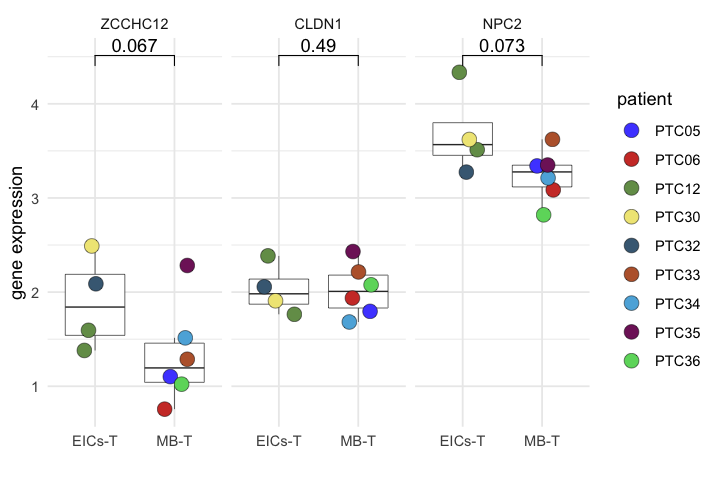

In [11]:
options(repr.plot.width=6, repr.plot.height=4)
sample_mean_exp %>%
  ggplot(aes(x=group, y=value))+
  geom_boxplot(outlier.shape = NA, size=0.2)+
  geom_jitter(aes(fill=patient),shape=21,width=0.2, size=4, stroke=0.2)+
  scale_fill_igv()+
  #scale_fill_gradientn(colors = patient9_color)+
  stat_compare_means(comparisons = list(c('MB-T', 'EICs-T')), label = "p.format",
     method = "t.test", 
     method.args = list(alternative = "less"))+
  facet_wrap(~Var1, ncol=3)+
  theme_minimal()+
  theme()+
  labs(x='', y='gene expression')

In [9]:
#### 比较基因box_plot ####
tmp_srt = readRDS('../output/clean_rds/97_sample_epithelial_mapping.rds')

In [10]:
tmp_srt

An object of class Seurat 
53145 features across 164614 samples within 4 assays 
Active assay: integrated (2610 features, 0 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, SCT, prediction.score.ref_data
 1 dimensional reduction calculated: umap

In [12]:
table(tmp_srt$batch, tmp_srt$Tissue_desc)

     
          B  LN_M     P     T
  new 15085     0 11057     0

In [13]:
only_B_srt = subset(tmp_srt, batch=='new')
only_B_srt = subset(only_B_srt, Tissue_desc%in%c('B'))

Warning message:
“Removing 138472 cells missing data for vars requested”


In [14]:
tmp_srt1 = subset(tmp_srt, patient%in%B_patient2)

In [15]:
tmp_srt2 = merge(tmp_srt1, only_B_srt)

In [16]:
keep_gene = c("ZCCHC12", "CLDN1",   "NPC2")

In [17]:
DefaultAssay(tmp_srt2) = "RNA"

tmp_srt2[['new_group2']] = tmp_srt2$Tissue_desc
tmp_srt2@meta.data[rownames(srt_B@meta.data[srt_B$Type=='NB',]), 'new_group2'] = 'MB'
tmp_srt2@meta.data[rownames(srt_B@meta.data[srt_B$Type=='EICs',]), 'new_group2'] = 'EICs'
#tmp_srt2[['new_group2']] = paste0(tmp_srt2$orig.ident, ';', tmp_srt2$new_group2)

In [18]:

sample_mean_exp = AverageExpression(tmp_srt2, group.by = 'new_group2', features = keep_gene)$RNA %>% log1p



Warning message:
“The following 3 features were not found in the prediction.score.ref_data assay: ZCCHC12, CLDN1, NPC2”
Warning message:
“None of the features specified were found in the prediction.score.ref_data assay.”


In [19]:
exprMatrix <- GetAssayData(tmp_srt2, slot = "data")
exprMatrix = as.matrix(exprMatrix[keep_gene,])

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


In [20]:
tmp_pos = tmp_srt2$new_group2%in%c('B','MB')
exprMatrix1 = exprMatrix[,!tmp_pos]
exprMatrix = exprMatrix[,tmp_pos]
batch = tmp_srt2$new_group2[tmp_pos]


In [21]:
library(sva)
corrected <- ComBat(dat = exprMatrix, batch = batch)

Found2batches



Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




In [22]:
corrected_melt = melt(corrected)
corrected_melt$orig.ident = tmp_srt2@meta.data[as.vector(corrected_melt$Var2), 'orig.ident']
corrected_melt$new_group2 = tmp_srt2@meta.data[as.vector(corrected_melt$Var2), 'new_group2']

In [23]:
exprMatrix1_melt = melt(exprMatrix1)
exprMatrix1_melt$orig.ident = tmp_srt2@meta.data[as.vector(exprMatrix1_melt$Var2), 'orig.ident']
exprMatrix1_melt$new_group2 = tmp_srt2@meta.data[as.vector(exprMatrix1_melt$Var2), 'new_group2']

In [24]:
corrected_melt2 = rbind(corrected_melt, exprMatrix1_melt)

`summarise()` has grouped output by 'orig.ident', 'new_group2'. You can override using the `.groups` argument.


Warning message in wilcox.test.default(c(0.506702179210654, 0.07216881055901, 0.887783630693647:
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.506702179210654, 0.07216881055901, 0.887783630693647:
“cannot compute exact p-value with ties”


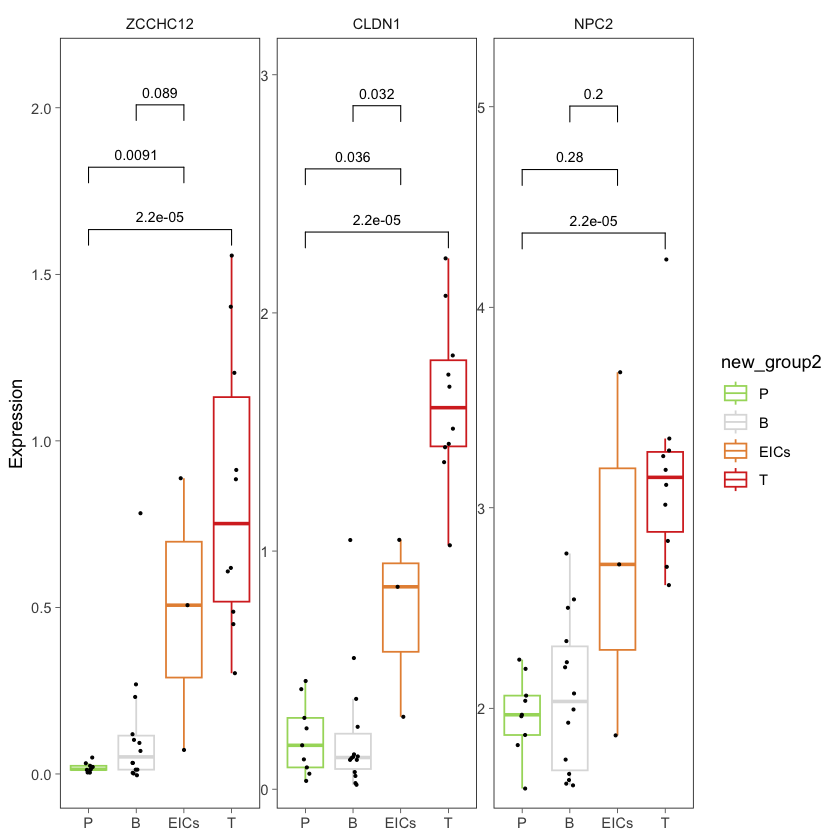

In [28]:
a=corrected_melt2 %>%
  group_by(orig.ident, new_group2,Var1) %>%
  summarise(mean = mean(value)) %>%
  mutate(new_group2=ifelse(new_group2=='MB', 'B', new_group2)) %>%
  mutate(new_group2 = factor(new_group2, levels = c('P', 'B', 'EICs', 'T')))%>%
  ggplot(aes(x=new_group2, y=mean))+
  geom_boxplot(aes(color=new_group2),outlier.shape = NA)+
  scale_color_manual(values = c('P'='#A6D96A', 'B'="#dddddd", 'EICs'='#E69042', 'T'="#D73027"))+
  geom_jitter(width=0.1, size=0.5)+
  scale_y_continuous(expand = c(0,0.1,0.1,0))+
  facet_wrap(~Var1, scales ='free_y', ncol=3)+
  stat_compare_means(comparisons = list(c('T', 'P'), c('P', 'EICs'), c('EICs', 'B')), label='p.fromat', size=3)+
  labs(y='Expression')+
  theme_bw()+
  theme(panel.grid = element_blank(),
        panel.spacing = unit(0, "lines"),
        #panel.background = element_rect(fill = NA, color = "black"),
        strip.background = element_blank(),
        #strip.text = element_text(face = "bold"),
        strip.text.y.left = element_text(size=10,angle = 90),
        #axis.text.x = element_text(angle=60, vjust=1,hjust=1),
        axis.line = element_blank(),
        axis.ticks = element_line(size=0.2), 
        axis.title.x = element_blank())
a
ggsave(glue('{output_dir}/marker在EICsdistribution(sample水平3).pdf'), a,
       width=160, height=70, units='mm', dpi = 450, bg = 'transparent')

`summarise()` has grouped output by 'orig.ident', 'new_group2'. You can
override using the `.groups` argument.
Warning message in wilcox.test.default(c(0.0129690374915063, 0.0129690374915063, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.506702179210654, 0.07216881055901, 0.887783630693647:
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0129690374915063, 0.0129690374915063, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.506702179210654, 0.07216881055901, 0.887783630693647:
“cannot compute exact p-value with ties”


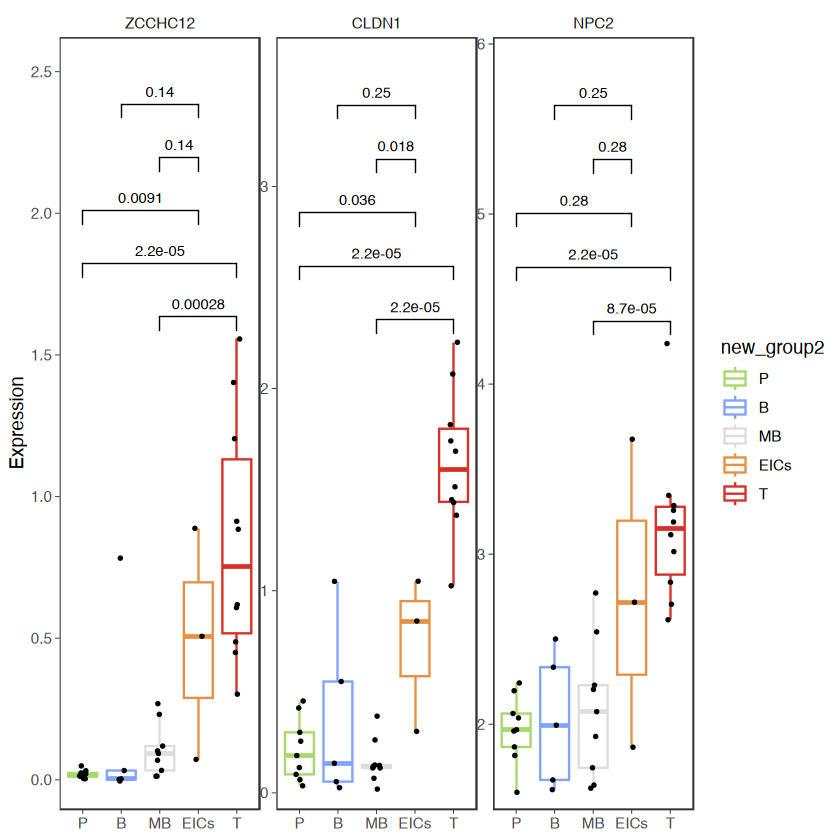

In [ ]:
a=corrected_melt2 %>%
  group_by(orig.ident, new_group2,Var1) %>%
  summarise(mean = mean(value)) %>%
  mutate(new_group2 = factor(new_group2, levels = c('P', 'B','MB', 'EICs', 'T')))%>%
  ggplot(aes(x=new_group2, y=mean))+
  geom_boxplot(aes(color=new_group2),outlier.shape = NA)+
  scale_color_manual(values = c('P'='#A6D96A', 'B'="#7fa3ffff",'MB'="#dddddd", 'EICs'='#E69042', 'T'="#D73027"))+
  geom_jitter(width=0.1, size=0.5)+
  scale_y_continuous(expand = c(0,0.1,0.1,0))+
  facet_wrap(~Var1, scales ='free_y', ncol=3)+
  stat_compare_means(comparisons = list(c('MB','T'), c('T', 'P'), c('P', 'EICs'), c('EICs', 'MB'), c('EICs', 'B')), label='p.fromat', size=3)+
  labs(y='Expression')+
  theme_bw()+
  theme(panel.grid = element_blank(),
        panel.spacing = unit(0, "lines"),
        #panel.background = element_rect(fill = NA, color = "black"),
        strip.background = element_blank(),
        #strip.text = element_text(face = "bold"),
        strip.text.y.left = element_text(size=10,angle = 90),
        #axis.text.x = element_text(angle=60, vjust=1,hjust=1),
        axis.line = element_blank(),
        axis.ticks = element_line(size=0.2), 
        axis.title.x = element_blank())
a
ggsave(glue('{output_dir}/marker在EICsdistribution(sample水平2).pdf'), a,
       width=160, height=70, units='mm', dpi = 450, bg = 'transparent')

`summarise()` has grouped output by 'orig.ident', 'new_group2'. You can
override using the `.groups` argument.


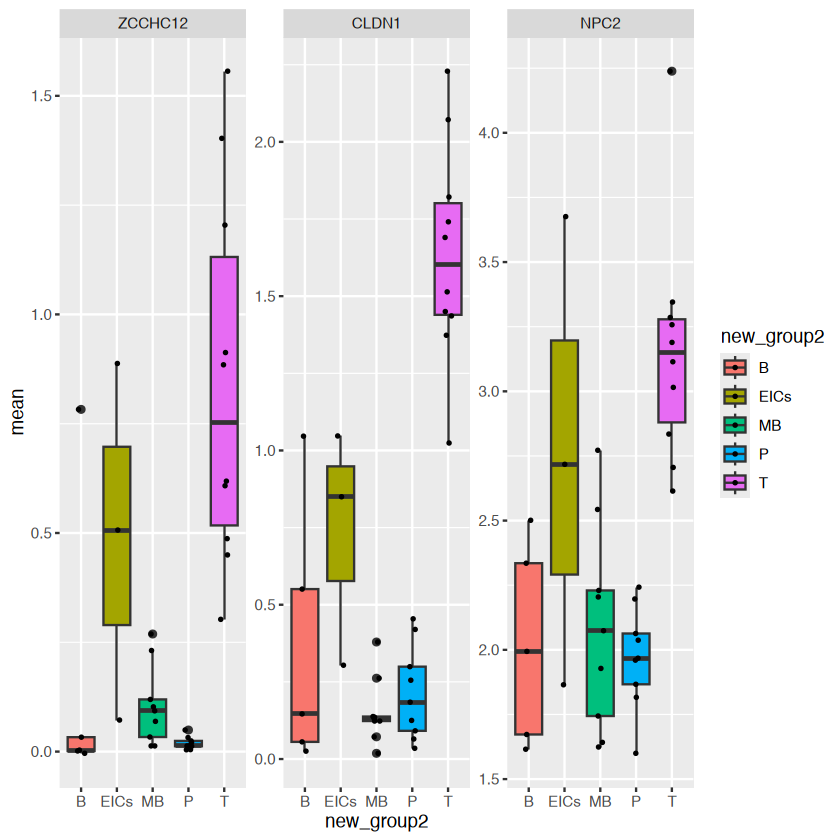

In [141]:
corrected_melt2 %>%
    group_by(orig.ident, new_group2,Var1) %>%
    summarise(mean = mean(value)) %>%
    ggplot(aes(x=new_group2, y=mean, fill=new_group2)) + 
    geom_boxplot() + 
    geom_jitter(width=0.1, size=0.5) +
    facet_wrap(~Var1, scales ='free_y', ncol=3)

In [ ]:
#sample_mean_exp = corrected

In [58]:
sample_mean_exp = melt(as.matrix(sample_mean_exp))
sample_mean_exp$Var2 = as.vector(sample_mean_exp$Var2)
sample_mean_exp$sample = sapply(sample_mean_exp$Var2, function(x)strsplit(x, ';')[[1]][1])
sample_mean_exp$group = sapply(sample_mean_exp$Var2, function(x)strsplit(x, ';')[[1]][2])

Warning message in wilcox.test.default(c(0, 0, 0.348607210825467, 0.113614728684803, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1.03195069160138, 0.19209621844853, 2.00576816820433:
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0, 0, 0.348607210825467, 0.113614728684803, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(1.03195069160138, 0.19209621844853, 2.00576816820433:
“cannot compute exact p-value with ties”


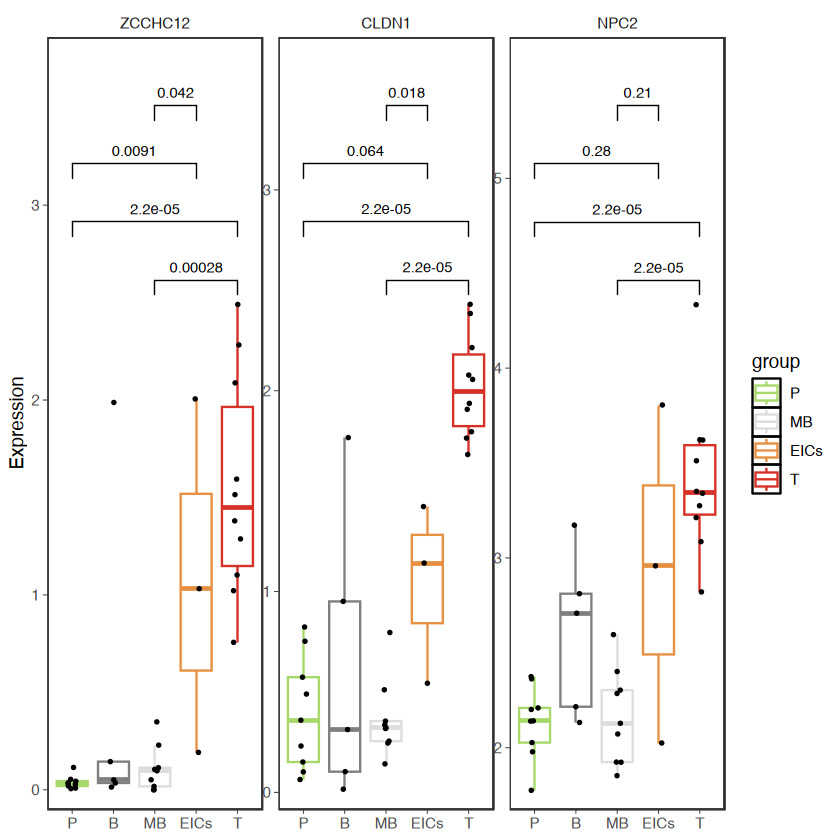

In [60]:


#sample_mean_exp$group[sample_mean_exp$group=='P'] = 'N'

a=sample_mean_exp %>%
  #filter(group!='B') %>%
  mutate(group = factor(group, levels = c('P', 'B','MB', 'EICs', 'T')))%>%
  ggplot(aes(x=group, y=value))+
  geom_boxplot(aes(color=group),outlier.shape = NA)+
  scale_color_manual(values = c('P'='#A6D96A', 'MB'="#dddddd", 'EICs'='#E69042', 'T'="#D73027"))+
  geom_jitter(width=0.1, size=0.5)+
  scale_y_continuous(expand = c(0,0.1,0.1,0))+
  facet_wrap(~Var1, scales ='free_y', ncol=3)+
  stat_compare_means(comparisons = list(c('MB','T'), c('T', 'P'), c('P', 'EICs'), c('EICs', 'MB')), label='p.fromat', size=3)+
  labs(y='Expression')+
  theme_bw()+
  theme(panel.grid = element_blank(),
        panel.spacing = unit(0, "lines"),
        panel.background = element_rect(fill = NA, color = "black"),
        strip.background = element_blank(),
        #strip.text = element_text(face = "bold"),
        strip.text.y.left = element_text(size=10,angle = 90),
        #axis.text.x = element_text(angle=60, vjust=1,hjust=1),
        axis.line = element_blank(),
        axis.ticks = element_line(size=0.2),
        axis.title.x = element_blank())
a
ggsave(glue('{output_dir}/marker在EICsdistribution(sample水平).pdf'), a,
       width=140, height=70, units='mm', dpi = 450, bg = 'transparent')


## 标记基因与恶性轨迹相关性

In [ ]:
tmp_srt = readRDS('../output/clean_rds/97_sample_epithelial_mapping.rds')

In [5]:
sample_mean_exp = AverageExpression(tmp_srt, group.by = 'orig.ident', features = keep_gene)$RNA %>% log1p


Warning message:
“The following 3 features were not found in the prediction.score.ref_data assay: ZCCHC12, CLDN1, NPC2”
Warning message:
“None of the features specified were found in the prediction.score.ref_data assay.”


In [40]:
sample_mean_exp = as.matrix(sample_mean_exp)
colnames(sample_mean_exp) = gsub('-','_',colnames(sample_mean_exp))

In [ ]:

ph_marker = read.table('../output/87sampleEpithelial_P_markers.csv', sep=',')
C4_marker = ph_marker %>% filter(cluster=='C4_SPARC',p_val_adj<0.05, avg_log2FC>0)
C5_marker = ph_marker %>% filter(cluster=='C5_HLA-DRA',p_val_adj<0.05, avg_log2FC>0)

hallmark_data = GSEABase::getGmt('../h.all.v7.4.symbols.gmt')
hallmark_data = hallmark_data@.Data
hallmark_list = list()
for(i in hallmark_data){
  hallmark_list[[i@setName]] = i@geneIds
}


Names of identity class contain underscores ('_'), replacing with dashes ('-')
This message is displayed once every 8 hours.
Warning message:
“The following 3 features were not found in the prediction.score.ref_data assay: ZCCHC12, CLDN1, NPC2”
Warning message:
“None of the features specified were found in the prediction.score.ref_data assay.”


In [11]:

DefaultAssay(tmp_srt) = 'RNA'
tmp_srt = AddModuleScore(tmp_srt, features = list(C4_marker$gene, C5_marker$gene,
                                          hallmark_list$HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,
                                          hallmark_list$HALLMARK_INTERFERON_ALPHA_RESPONSE,
                                          hallmark_list$HALLMARK_INTERFERON_GAMMA_RESPONSE
                                          )
)
tmp_srt = AddModuleScore(tmp_srt, features = list(TDS_marker,BRAF_marker, RAS_marker),name = c('TDS','BRAF','RAS'))


Warning message:
“The following features are not present in the object: WARS1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: WARS1, MARCHF1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: ANXA2P2, not searching for symbol synonyms”


In [ ]:
sample_score = tmp_srt@meta.data %>% 
  group_by(orig.ident) %>% 
  summarise(C4_score=mean(Cluster1),
            C5_score=mean(Cluster2),
            EMT_score=mean(Cluster3),
            INFa_score=mean(Cluster4),
            INFb_score=mean(Cluster5),
            TDS_score=mean(TDS1),
            BRAF_score=mean(BRAF2),
            RAS_score=mean(RAS3)) %>%
  as.data.frame()
rownames(sample_score) = sample_score$orig.ident
sample_score$Malignancy=pc_df[sample_score$orig.ident, 'Pseudotime']
sample_score = melt(sample_score, id.vars = 'orig.ident')
colnames(sample_score) = c('sample', 'group', 'value')

In [45]:
sample_mean_exp = melt(sample_mean_exp)
colnames(sample_mean_exp) = c('Marker', 'sample', 'Mean_exp')

In [47]:
pc_df = readRDS('../organized_data/trajectory_projection_97sample.rds')
rownames(pc_df) = pc_df$sample
merge_data = merge(sample_mean_exp,sample_score)

In [48]:

merge_data[, 'line_type'] = 'down'
merge_data[merge_data$group%in%c('TDS_score','RAS_score'), 'line_type'] = 'up'


Warning message:
“The dot-dot notation (`..r.label..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(r.label)` instead.”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


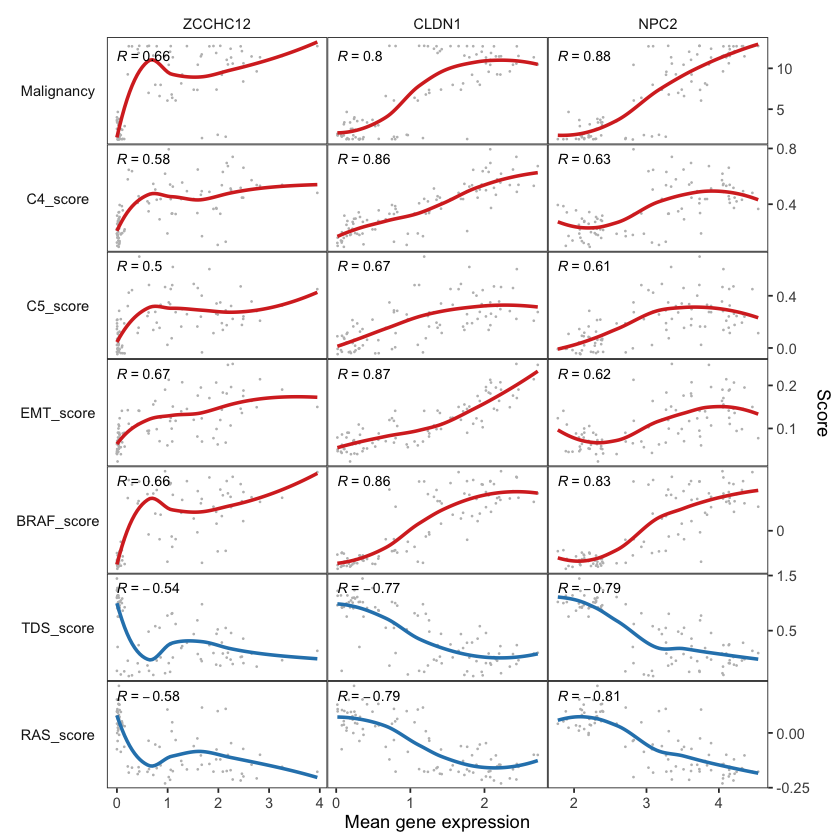

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


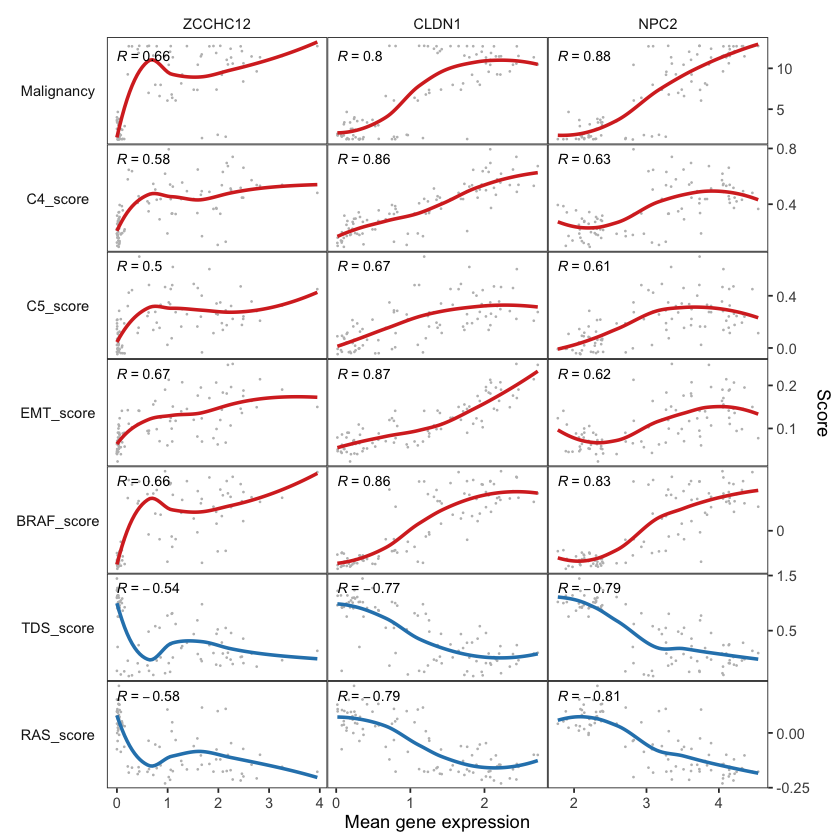

In [50]:

keep_show = c('Malignancy', 'C4_score','C5_score','EMT_score','BRAF_score',
              'TDS_score','RAS_score')
a=merge_data %>%
  filter(group%in%keep_show) %>%
  mutate(group=factor(group, keep_show)) %>%
  ggplot(aes(x=Mean_exp, y=value))+
  geom_point(size=0.1, color='gray')+
  geom_smooth(aes(color=line_type),se=F, show.legend = F)+
  stat_cor(aes(label = ..r.label..), size=3,)+
  facet_grid(group~Marker, scales = 'free', switch = 'y')+
  scale_y_continuous(position='right',  
                     breaks =scales::extended_breaks(n = 3))+
  labs(x='Mean gene expression', y='Score')+
  scale_color_manual(values = c('down'='#D73027', 'up'='#2B83BA'), )+
  theme_bw()+
  theme(panel.spacing = unit(0, "lines"),
        panel.grid = element_blank(),
        strip.background = element_blank(),
        #axis.text = element_blank(),
        #axis.ticks = element_blank(),
        strip.text.y.left = element_text( angle = 0)
        )
a
#a=ggplot_build(a)
#a$data[[3]]
a
ggsave(glue('{output_dir}/marker与不同评分的相关性.pdf'), a,
       width=100, height=150, units='mm', dpi = 450, bg = 'transparent')


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


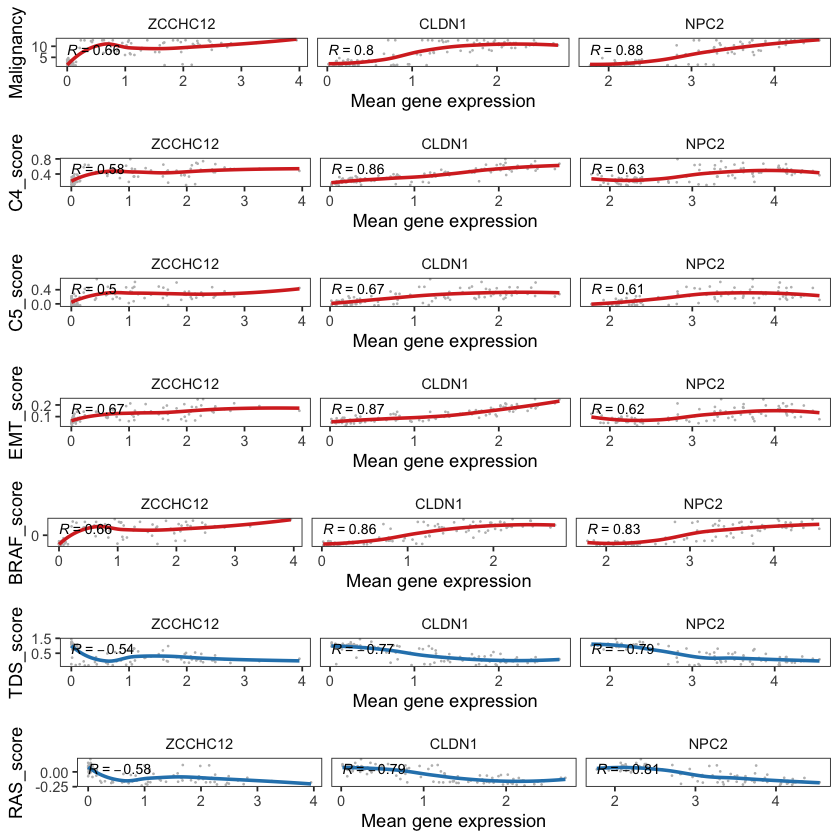

In [52]:
all_p = list()
for(i in keep_show){
  tmp_a = merge_data %>%
    filter(group%in%i ) %>%
    ggplot(aes(x=Mean_exp, y=value))+
    geom_point(size=0.1, color='gray')+
    geom_smooth(aes(color=line_type),se=F, show.legend = F)+
    stat_cor(aes(label = ..r.label..), size=3,)+
    facet_grid(~Marker, scales = 'free', switch = 'y')+
    scale_y_continuous(breaks =scales::extended_breaks(n = 3))+
    labs(x='Mean gene expression', y=i)+
    scale_color_manual(values = c('down'='#D73027', 'up'='#2B83BA'), )+
    theme_bw()+
    theme(#panel.spacing = unit(0, "lines"),
          panel.grid = element_blank(),
          strip.background = element_blank(),
          #axis.text = element_blank(),
          #axis.ticks = element_blank(),
          strip.text.y.left = element_text( angle = 0)
    )
  all_p[[i]] = tmp_a
}

a = cowplot::plot_grid(plotlist = all_p, ncol=1)
a
ggsave(glue('{output_dir}/marker与不同评分的相关性2.pdf'), a,
       width=100, height=280, units='mm', dpi = 450, bg = 'transparent')


## 与代谢相关性

In [61]:
sc_mb_score = readRDS('../organized_data/merge_df.rds') 
sc_mb_score = sc_mb_score %>%arrange(Pseudotime)
sc_mb_score_mat = t(sc_mb_score[,12:ncol(sc_mb_score)])
colnames(sc_mb_score_mat) = sc_mb_score$sample

In [64]:
sc_mb_score_df = melt(sc_mb_score_mat[c('Cholesterol metabolism',
    'Glycerophospholipid metabolism',
    'Arachidonic acid metabolism'), ])
colnames(sc_mb_score_df) = c('metabolism', 'sample', 'metabolism_score')

In [65]:
merge_data2 = merge(sample_mean_exp,sc_mb_score_df)

In [68]:
keep_show_mb = c('Cholesterol metabolism',
    'Glycerophospholipid metabolism',
    'Arachidonic acid metabolism')

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


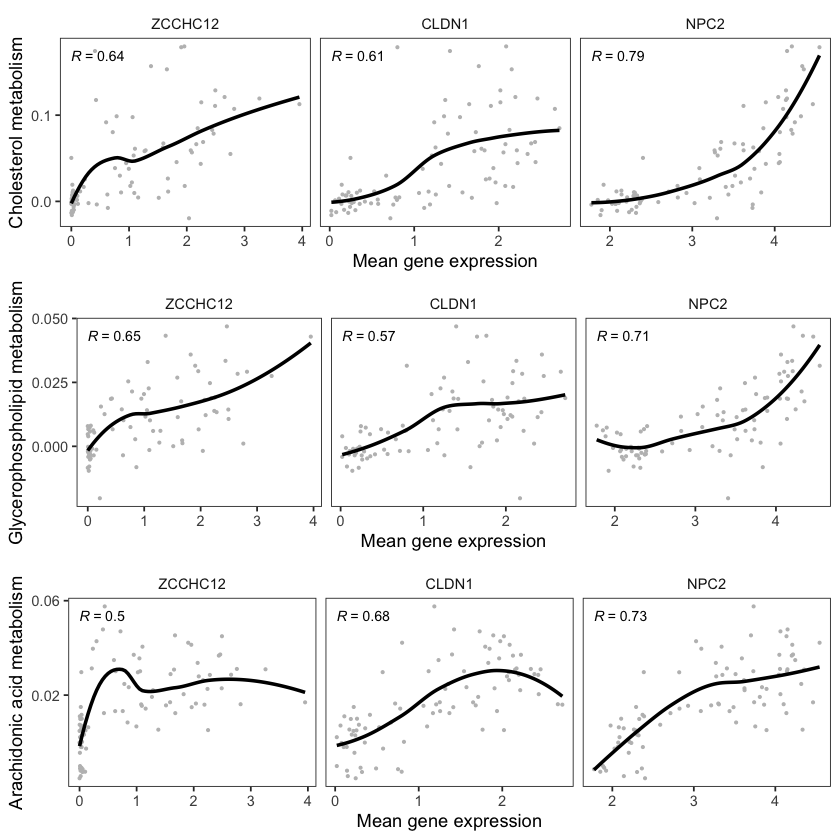

In [80]:
all_p = list()
for(i in keep_show_mb){
  tmp_a = merge_data2 %>%
    filter(metabolism%in%i ) %>%
    ggplot(aes(x=Mean_exp, y=metabolism_score))+
    geom_point(size=0.5, color='gray')+
    geom_smooth(se=F, show.legend = F, color='black')+
    stat_cor(aes(label = ..r.label..), size=3)+
    facet_grid(~Marker, scales = 'free', switch = 'y')+
    scale_y_continuous(breaks =scales::extended_breaks(n = 3))+
    labs(x='Mean gene expression', y=i)+
    scale_color_manual(values = c('down'='#D73027', 'up'='#2B83BA'), )+
    theme_bw()+
    theme(#panel.spacing = unit(0, "lines"),
          panel.grid = element_blank(),
          strip.background = element_blank(),
          #axis.text = element_blank(),
          #axis.ticks = element_blank(),
          strip.text.y.left = element_text( angle = 0)
    )
  all_p[[i]] = tmp_a
}

a = cowplot::plot_grid(plotlist = all_p, ncol=1)
a
ggsave(glue('{output_dir}/marker与代谢评分的相关性.pdf'), a,
       width=160, height=200, units='mm', dpi = 450, bg = 'transparent')


# EIC与非EIC的比较

In [48]:
srt_B = readRDS('../output/MB_B.rds')
mal_B = c('TC028_T3_1', 'TC045_B_2', 'TC047_B_2')
srt_B[['Type']] = 'NB'
srt_B@meta.data[srt_B$malignant_tendencies=='Yes', 'Type'] = 'EICs'


In [ ]:
DefaultAssay(srt_B) = 'RNA'

[1] 2610

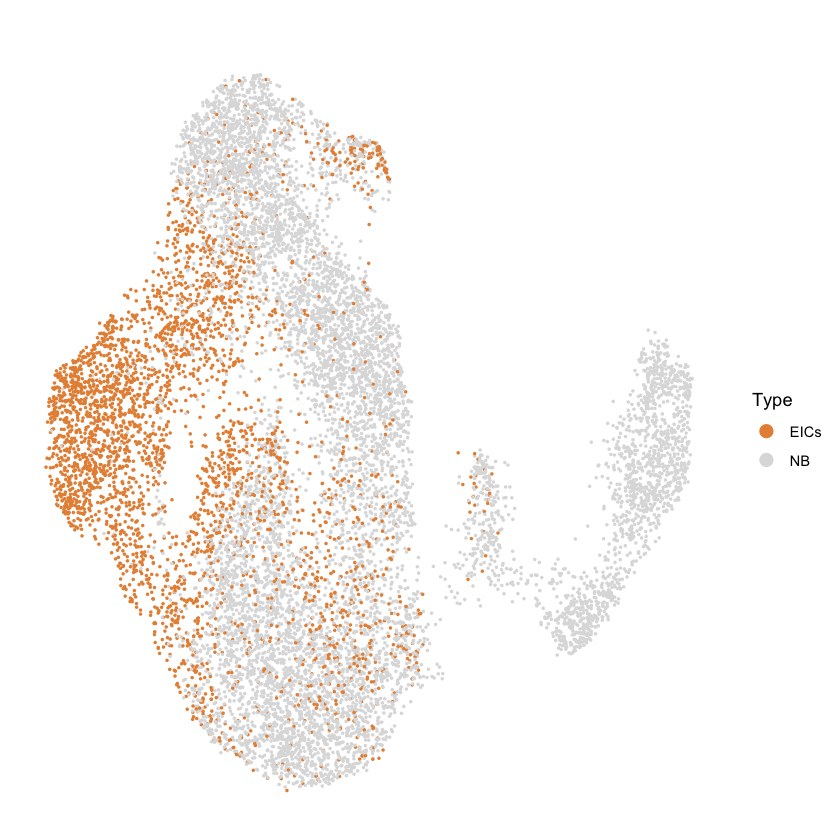

In [50]:
umap = as.data.frame(srt_B@reductions$umap@cell.embeddings)
umap$Type = srt_B$Type#factor(srt_B$Type, c('NB','EICs'))
#umap = umap %>% arrange(Type)
all_cells=umap %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  geom_point(aes(fill=Type),shape=21,size=1, stroke=NA)+
  scale_fill_manual(values = c('NB'='#dddddd', 'EICs'='#E69042'))+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )+
  guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
all_cells

## HALLMARK

In [10]:
other_srt = readRDS('../output/clean_rds/All_ann_97_new.rds')

In [11]:
other_srt = subset(other_srt, Tissue_desc=='B')
other_srt = subset(other_srt, Cluster=='Epithelial')
other_srt = subset(other_srt, batch=='new')

In [12]:
#### Calculate scores method 1 ####
hallmark_data = GSEABase::getGmt('../h.all.v7.4.symbols.gmt')
hallmark_data = hallmark_data@.Data
hallmark_list = list()
for(i in hallmark_data){
  hallmark_list[[i@setName]] = i@geneIds
}
hallmark_list_all_num = sapply(hallmark_list, length)
names(hallmark_list_all_num) = gsub('HALLMARK_','',names(hallmark_list_all_num))


In [13]:
# Identify differential genes between EICs and NB
# DefaultAssay(srt_B) = 'RNA'
# Idents(srt_B) = srt_B$Type
# all_cells = FindAllMarkers(srt_B, logfc.threshold = 0.25, min.pct = 0.1, min.diff.pct = 0.1)

In [14]:
hallmark_list_filter = hallmark_list

In [15]:
srt1 = merge(srt_B, other_srt)

ERROR: Error in merge(srt_B, other_srt): object 'srt_B' not found


In [ ]:
srt1

In [ ]:
srt1$B_group = srt1$Type
srt1$B_group[is.na(srt1$B_group)] = 'B'
srt1$B_group[srt1$B_group=='NB'] = 'MB'
table(srt1$B_group)

In [12]:
srt2 = AddModuleScore(srt1, features = hallmark_list_filter, name = names(hallmark_list_filter))


Warning message:
“The following features are not present in the object: LALBA, not searching for symbol synonyms”


Warning message:
“The following features are not present in the object: REG1A, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: POLR1H, TK2, MPC2, MRPL40, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: H2AX, H2AZ1, H2BC12, RPS6KA5, PTTG3P, H2AZ2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: DIABLO, GPX1, H1-0, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: GPAM, GRPEL1, ALDH2, MTCH2, IMMT, MTARC2, MRPL15, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: RPS6KA2, RRP12, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: GFUS, RPS6KA2, IDH2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the o

In [13]:
saveRDS(srt2, '../output/clean_rds/EIC_hallmark.rds')

In [48]:
srt1

An object of class Seurat 
53145 features across 27671 samples within 4 assays 
Active assay: RNA (30077 features, 0 variable features)
 2 layers present: counts, data
 3 other assays present: SCT, integrated, prediction.score.ref_data

In [55]:
table(srt2$B_group)


    B  EICs    MB 
15085  3517  9069 

In [28]:
up_score = srt2@meta.data[,c(grep('HALLMARK_', colnames(srt2@meta.data), value = T))]

In [29]:
# Identify gene differences between EICs and MB and B
diff_score = c()
for(i in colnames(up_score)){
  tmp = wilcox.test(up_score[srt_B$Type!='EICs',i], up_score[srt_B$Type=='EICs',i])
  diff_score = rbind(diff_score, data.frame(Score=i, p.value=tmp$p.value, 
                                             NB_mean=mean(up_score[srt_B$Type!='EICs',i]),
                                             EICs_mean=mean(up_score[srt_B$Type=='EICs',i])))
}
diff_score = diff_score %>% arrange(p.value)
diff_score$Score = gsub('HALLMARK_','', diff_score$Score)
diff_score$Score = gsub('\\d*$','', diff_score$Score)
diff_score[diff_score$EICs_mean>diff_score$NB_mean, 'direction'] = 'up'

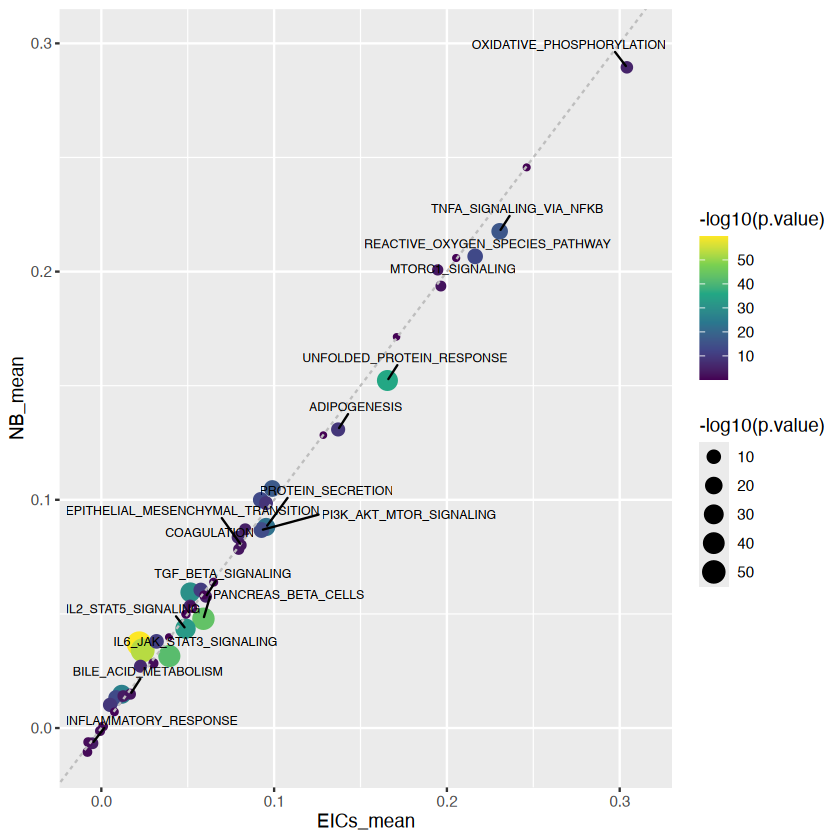

In [30]:
a=diff_score %>%
    ggplot(aes(x=EICs_mean, y=NB_mean))+
    geom_point(aes(size=-log10(p.value), color=-log10(p.value)))+
    geom_abline(slope=1, intercept = 0, linetype='dashed', color='gray')+
    #geom_smooth(method='lm')+
    geom_text_repel(aes(label=Score), size=2.5, nudge_x = 0.01, nudge_y = 0.01, data=diff_score%>% filter(direction=='up', p.value<0.01))+
    scale_color_viridis_c()
a

In [31]:
ggsave(glue('{output_dir}/EIC差异HALLMARK_scatter_plot.pdf'), a,
       width=160, height=140, units='mm', dpi = 450, bg = 'transparent')

In [32]:
colnames(up_score) = gsub('HALLMARK_','', colnames(up_score))
colnames(up_score) = gsub('\\d*$','', colnames(up_score))

In [33]:
# h2=Heatmap(t(up_score),
#            show_row_dend = F, show_column_names = F,
#            col = circlize::colorRamp2(c(-1,-0.5,0, 0.5, 1), c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C")),
#            heatmap_legend_param = list('title'='EnrichScore'),
#            column_split = factor(srt2$B_group),
# )
# pdf(glue('{output_dir}/EIC差异HALLMARK.pdf'), width=8, height=6)
# h2
# dev.off()

In [34]:
keep_show_diff_score = diff_score %>% filter(p.value<0.05, direction=='up') %>% arrange(-EICs_mean+NB_mean)
keep_show_diff_score

Score,p.value,NB_mean,EICs_mean,direction
<chr>,<dbl>,<dbl>,<dbl>,<chr>
OXIDATIVE_PHOSPHORYLATION,5.673110e-06,0.289496869,0.3041586868,up
UNFOLDED_PROTEIN_RESPONSE,2.059608e-36,0.152283769,0.1655825117,up
TNFA_SIGNALING_VIA_NFKB,3.910850e-17,0.217647838,0.2305224213,up
PANCREAS_BETA_CELLS,2.950898e-44,0.047884886,0.0590979933,up
REACTIVE_OXYGEN_SPECIES_PATHWAY,7.152747e-14,0.206669527,0.2163515068,up
IL6_JAK_STAT3_SIGNALING,1.321829e-42,0.031552189,0.0393547286,up
PROTEIN_SECRETION,2.861678e-23,0.088102442,0.0954098683,up
ADIPOGENESIS,1.244801e-09,0.130829907,0.1370501332,up
PI3K_AKT_MTOR_SIGNALING,1.540222e-14,0.086760047,0.0927110971,up


In [37]:
figure2_hallmarke_res = read.table('../organized_data/trajectory_enrichment_hallmark97.txt') %>% filter(group=='up')
figure2_hallmarke_res


,hallmark,group
,<chr>,<chr>
1,CHOLESTEROL_HOMEOSTASIS,up
2,MITOTIC_SPINDLE,up
3,APOPTOSIS,up
4,ESTROGEN_RESPONSE_EARLY,up
5,ANDROGEN_RESPONSE,up
6,MYOGENESIS,up
7,INTERFERON_ALPHA_RESPONSE,up
8,INTERFERON_GAMMA_RESPONSE,up
9,APICAL_JUNCTION,up


In [39]:
keep_show_diff_score2 = keep_show_diff_score %>% filter(Score %in% figure2_hallmarke_res$hallmark)

In [43]:
keep_show_diff_score2 = keep_show_diff_score2 %>% filter(Score!='MITOTIC_SPINDLE')

In [44]:
select_hall_score = up_score[,keep_show_diff_score2$Score]
select_hall_score$B_group = srt2$B_group
select_hall_score = melt(select_hall_score, id='B_group')
colnames(select_hall_score) = c('B_group', 'Pathway', 'Score')

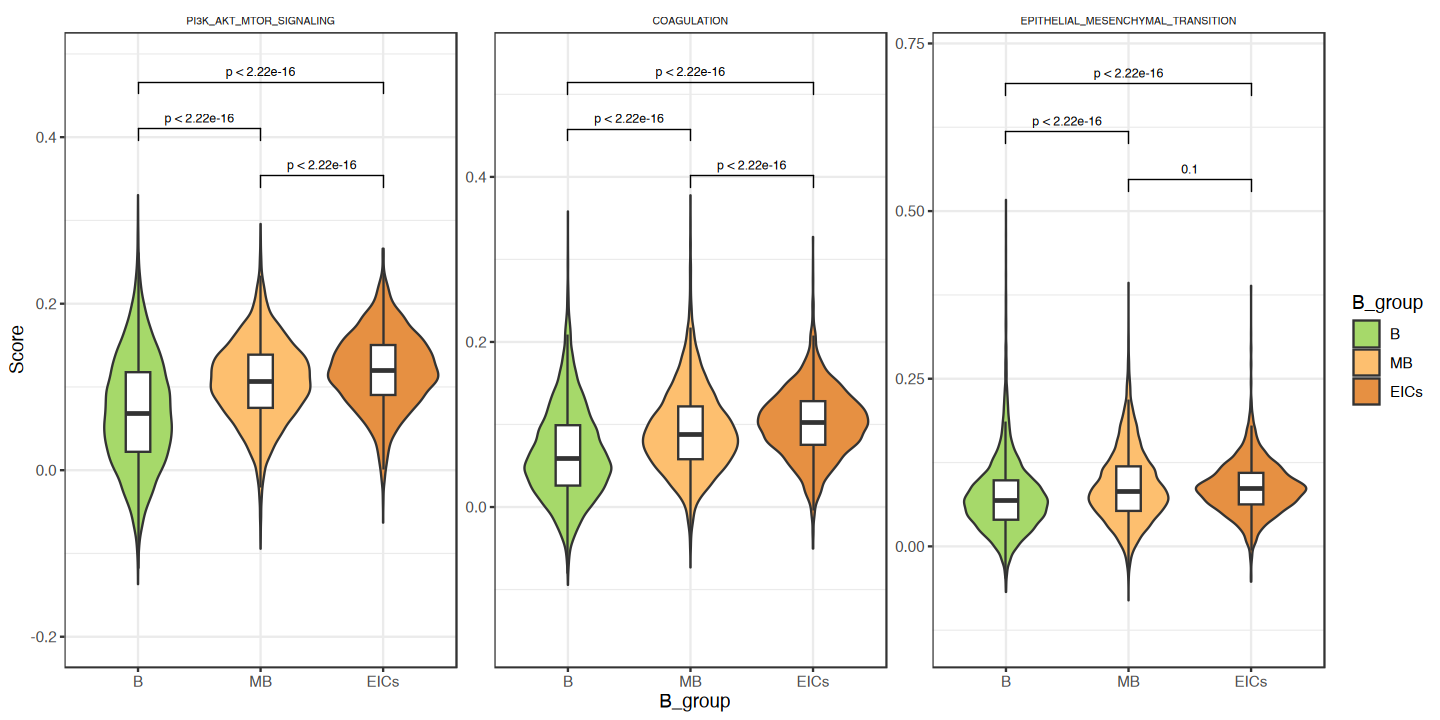

In [47]:
options(repr.plot.width=12, repr.plot.height=6)
a=select_hall_score %>%
    mutate(B_group = factor(B_group, levels = c('B', 'MB', 'EICs'))) %>%
    ggplot(aes(x=B_group, y=Score))+
    geom_violin(aes(fill=B_group))+
    geom_boxplot(width=0.2, outlier.shape = NA)+
    scale_fill_manual(values = c('B'='#A6D96A','MB'='#FDBF6F', 'EICs'='#E69042'))+
    facet_wrap(~Pathway, scales = 'free_y', ncol=6)+
    stat_compare_means(comparisons = list(c('MB','EICs'),c('MB','B'),c('B','EICs')), label='p.format', size=2.5)+
    scale_y_continuous(expand = c(0,0.1,0.1,0))+
    theme_bw()+ 
    theme(strip.background = element_blank(),
          strip.text = element_text(size=6, face='bold'))
a
ggsave(glue('{output_dir}/EIC差异HALLMARK_小提琴.pdf'), a,
       width=150, height=60, units='mm', dpi = 450, bg = 'transparent')

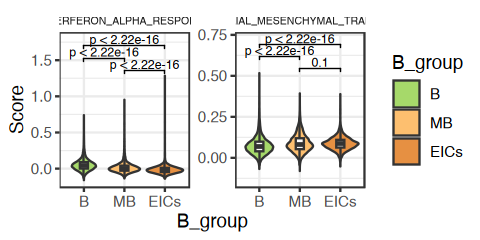

In [87]:
show_select = c('INTERFERON_ALPHA_RESPONSE','EPITHELIAL_MESENCHYMAL_TRANSITION')
options(repr.plot.width=4, repr.plot.height=2)
select_hall_score = up_score[,show_select]
select_hall_score$B_group = srt2$B_group
select_hall_score = melt(select_hall_score, id='B_group')
colnames(select_hall_score) = c('B_group', 'Pathway', 'Score')
a=select_hall_score %>%
    mutate(B_group = factor(B_group, levels = c('B', 'MB', 'EICs'))) %>%
    ggplot(aes(x=B_group, y=Score))+
    geom_violin(aes(fill=B_group))+
    geom_boxplot(width=0.2, outlier.shape = NA)+
    scale_fill_manual(values = c('B'='#A6D96A','MB'='#FDBF6F', 'EICs'='#E69042'))+
    facet_wrap(~Pathway, scales = 'free_y', ncol=6)+
    stat_compare_means(comparisons = list(c('MB','EICs'),c('MB','B'),c('B','EICs')), label='p.format', size=2.5)+
    scale_y_continuous(expand = c(0,0.1,0.1,0))+
    theme_bw()+ 
    theme(strip.background = element_blank(),
          strip.text = element_text(size=6, face='bold'))
a
ggsave(glue('{output_dir}/EIC差异HALLMARK_小提琴2.pdf'), a,
       width=120, height=60, units='mm', dpi = 450, bg = 'transparent')

## 代谢比较

In [3]:
mb_pathway = readRDS('../../hsa_KEGG_pathway_name(1).rds')

In [15]:
srt3 = AddModuleScore(srt1, features = mb_pathway, name = names(mb_pathway))

Warning message:
“The following features are not present in the object: PGK2, ALDH2, G6PC1, PCK2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: IDH2, PCK2, not searching for symbol synonyms”


Warning message:
“The following features are not present in the object: TKTL2, PRPS1L1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: UGT2A1, UGT2B28, UGT1A10, UGT1A8, UGT1A5, UGT1A9, UGT1A4, UGT1A3, UGT2A2, UGT2B4, UGT2B10, UGT2B15, UGT2A3, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: GFUS, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: G6PC1, LALBA, SI, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: UGT2A1, UGT2B28, UGT1A10, UGT1A8, UGT1A5, UGT1A9, UGT1A4, UGT1A3, UGT2A2, UGT2B4, UGT2B10, UGT2B15, UGT2A3, ALDH2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: OXSM, MECR, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: MECR, not s

In [43]:
other_srt = readRDS('../output/clean_rds/All_ann_97_new.rds')

In [44]:
select_mb = c('Cholesterol metabolism',
                                                  'Glycerophospholipid metabolism',
                                                  'Arachidonic acid metabolism',
                                                  'Tyrosine metabolism',
                                                  'Thyroid hormone synthesis')

In [45]:
mb_pathway[select_mb]

$`Cholesterol metabolism`
 [1] "ABCA1"   "APOA1"   "LPL"     "LCAT"    "LIPG"    "PLTP"    "CETP"   
 [8] "LIPC"    "LPA"     "CD36"    "LDLR"    "NCEH1"   "SOAT1"   "SOAT2"  
[15] "APOC1"   "APOC2"   "APOH"    "ANGPTL3" "ANGPTL4" "ANGPTL8" "SCARB1" 
[22] "SORT1"   "APOB"    "PCSK9"   "LDLRAP1" "MYLIP"   "APOE"    "LRP1"   
[29] "LRP2"    "LRPAP1"  "LIPA"    "STARD3"  "VDAC1"   "VDAC2"   "VDAC3"  
[36] "TSPO"    "CYP27A1" "VAPA"    "VAPB"    "NPC1"    "OSBPL5"  "NPC2"   
[43] "STAR"    "CIDEB"   "CYP7A1"  "ABCB11"  "ABCG5"   "ABCG8"   "APOA2"  
[50] "APOC3"   "APOA4"  

$`Glycerophospholipid metabolism`
  [1] "GPD1L"                                                                          
  [2] "GPD1"                                                                           
  [3] "GPD2"                                                                           
  [4] "glycerol-3-phosphate acyltransferase 2, mitochondrial [KO:K00629] [EC:2.3.1.15]"
  [5] "GPAT2"                                                                          
  [6] "GPAM"                                                                           
  [7] "GPAT4"                                                                          
  [8] "GPAT3"                                                                          
  [9] "AGPAT1"                                                                         
 [10] "AGPAT2"                                                                         
 [11] "AGPAT3"                                                                         
 [12] "AGPAT4"                                                                         
 [13] "AGPAT5"                                                                         
 [14] "LCLAT1"                                                                         
 [15] "MBOAT2"                                                                         
 [16] "MBOAT1"                                                                         
 [17] "GNPAT"                                                                          
 [18] "ADPRM"                                                                          
 [19] "PLPP1"                                                                          
 [20] "PLPP2"                                                                          
 [21] "PLPP3"                                                                          
 [22] "LPIN1"                                                                          
 [23] "LPIN3"                                                                          
 [24] "LPIN2"                                                                          
 [25] "PLPP4"                                                                          
 [26] "PLPP5"                                                                          
 [27] "DGKK"                                                                           
 [28] "DGKA"                                                                           
 [29] "DGKB"                                                                           
 [30] "DGKG"                                                                           
 [31] "DGKH"                                                                           
 [32] "DGKQ"                                                                           
 [33] "DGKZ"                                                                           
 [34] "DGKE"                                                                           
 [35] "DGKD"                                                                           
 [36] "DGKI"                                                                           
 [37] "CHPT1"                                                                          
 [38] "CEPT1"                                                                          
 [39] "SAMD8"                                

In [46]:
other_srt = AddModuleScore(other_srt, features = mb_pathway[select_mb], name = select_mb)

Warning message:
“The following features are not present in the object: glycerol-3-phosphate acyltransferase 2, mitochondrial [KO:K00629] [EC:2.3.1.15], GPAT2, GPAM, JMJD7-PLA2G4B, TAFAZZIN, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: JMJD7-PLA2G4B, AKR1C8, PTGR3, CYP4F2, CYP2C19, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: GOT1L1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: TSHB, PRKACG, GPX6, GPX1, GPX5, not searching for symbol synonyms”


In [47]:
saveRDS(other_srt, '../output/clean_rds/EIC_代谢other_srt.rds')

In [ ]:
other_srt = readRDS('../output/clean_rds/EIC_代谢other_srt.rds')

In [16]:
saveRDS(srt3, '../output/clean_rds/EIC_代谢.rds')

In [7]:
srt3 = readRDS('../output/clean_rds/EIC_代谢.rds')

In [8]:
table(srt3$Tissue_desc)


    B 
27671 

In [25]:
mb_score = srt3@meta.data[,setdiff(colnames(srt3@meta.data), colnames(srt1@meta.data))]

In [26]:

colnames(mb_score) = gsub('\\d*$','', colnames(mb_score))

In [27]:
# h2=Heatmap(t(mb_score),
#            show_row_dend = F, show_column_names = F,
#            col = circlize::colorRamp2(c(-1,-0.5,0, 0.5, 1), c("#762A83", "#AF8DC3", "#E0E0E0", "#F7D458", "#D7191C")),
#            heatmap_legend_param = list('title'='EnrichScore'),
#            column_split = factor(srt3$B_group),
# )
# pdf(glue('{output_dir}/EIC差异代谢.pdf'), width=12, height=8)
# h2
# dev.off()

In [28]:
# Identify differential metabolism scores for srt3$Type
diff_mb_score = c()
for(i in colnames(mb_score)){
  tmp = wilcox.test(mb_score[srt1$B_group!='EICs',i], mb_score[srt1$B_group=='EICs',i])
  diff_mb_score = rbind(diff_mb_score, data.frame(Score=i, p.value=tmp$p.value,
                                                  NB_mean=mean(mb_score[srt1$B_group!='EICs',i]),
                                                  EICs_mean=mean(mb_score[srt1$B_group=='EICs',i])))
}


In [29]:
diff_mb_score$Score = gsub('\\d*$','', diff_mb_score$Score)
diff_mb_score[diff_mb_score$EICs_mean>diff_mb_score$NB_mean, 'direction'] = 'up'

In [30]:
sc_mb_score = readRDS('../organized_data/merge_df.rds') 

In [31]:
dim(sc_mb_score)

[1]  85 121

In [32]:
diff_mb_score$adj = p.adjust(diff_mb_score$p.value, method = 'BH')

In [33]:
diff_mb_score2 = diff_mb_score%>% filter(Score%in% colnames(sc_mb_score))

In [34]:
select_mb = c('Cholesterol metabolism',
                                                  'Glycerophospholipid metabolism',
                                                  'Arachidonic acid metabolism',
                                                  'Tyrosine metabolism',
                                                  'Thyroid hormone synthesis')

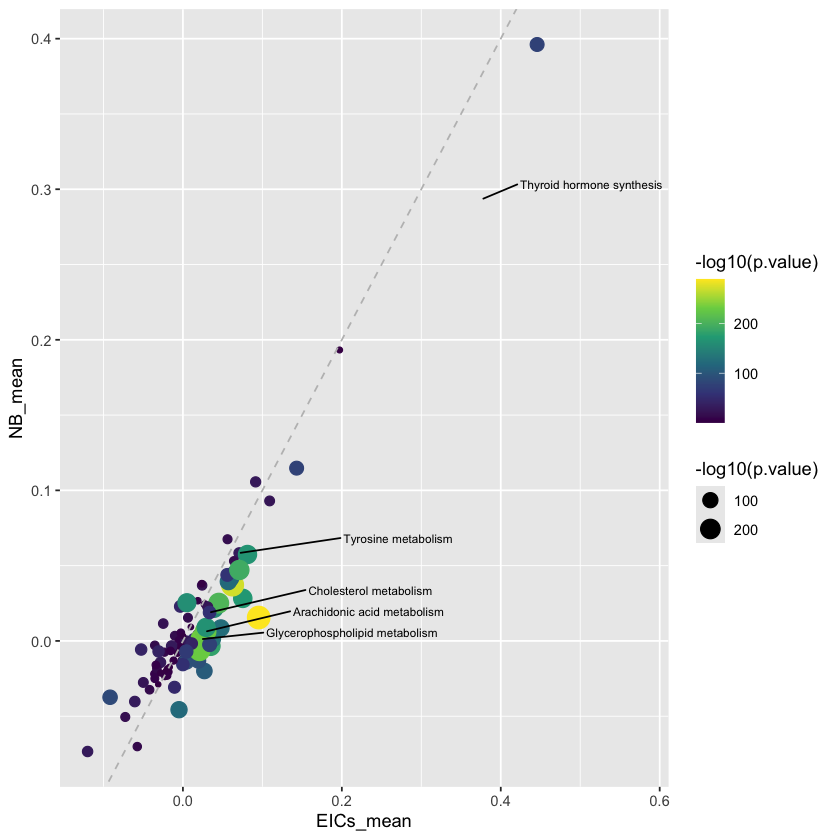

In [47]:
a=diff_mb_score2 %>%
    ggplot(aes(x=EICs_mean, y=NB_mean))+
    geom_point(aes(size=-log10(p.value), color=-log10(p.value)))+
    geom_abline(slope=1, intercept = 0, linetype='dashed', color='gray')+
    #geom_smooth(method='lm')+
    geom_text_repel(aes(label=Score), size=2.5, nudge_x = 0.2, nudge_y = 0.01, 
    data=diff_mb_score2%>% filter(direction=='up', p.value<0.001, Score%in%select_mb))+
    scale_color_viridis_c()
a

In [27]:
ggsave(glue('{output_dir}/EIC差异代谢_scatter_plot.pdf'), a,
       width=160, height=140, units='mm', dpi = 450, bg = 'transparent')

In [39]:
select_mb_score = mb_score[,select_mb]
select_mb_score$B_group = srt3$B_group
select_mb_score = melt(select_mb_score, id='B_group')
colnames(select_mb_score) = c('B_group', 'Pathway', 'Score')

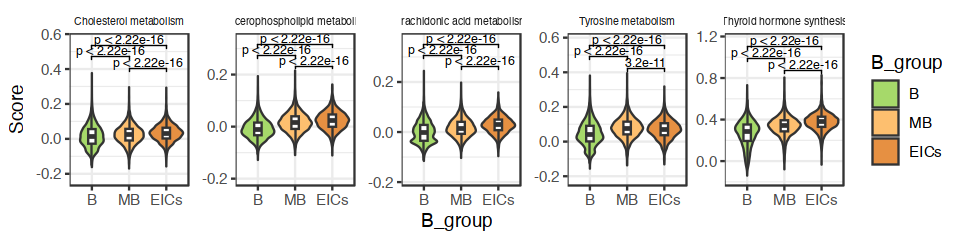

In [40]:
options(repr.plot.width=8, repr.plot.height=2)
a=select_mb_score %>%
    mutate(B_group = factor(B_group, levels = c('B', 'MB', 'EICs'))) %>%
    ggplot(aes(x=B_group, y=Score))+
    geom_violin(aes(fill=B_group))+
    geom_boxplot(width=0.2, outlier.shape = NA)+
    scale_fill_manual(values = c('B'='#A6D96A','MB'='#FDBF6F', 'EICs'='#E69042'))+
    facet_wrap(~Pathway, scales = 'free_y', ncol=6)+
    stat_compare_means(comparisons = list(c('MB','EICs'),c('MB','B'),c('B','EICs')), label='p.format', size=2.5)+
    scale_y_continuous(expand = c(0,0.1,0.1,0))+
    theme_bw()+ 
    theme(strip.background = element_blank(),
          strip.text = element_text(size=6, face='bold'))
a
ggsave(glue('{output_dir}/EIC差异代谢_小提琴2.pdf'), a,
       width=240, height=60, units='mm', dpi = 450, bg = 'transparent')

In [41]:
select_mb_score = mb_score[,select_mb]
select_mb_score$B_group = srt3$B_group

In [48]:
select_mb_score2 = other_srt@meta.data[, c('Tissue_desc','Cholesterol metabolism1',
                                                  'Glycerophospholipid metabolism2',
                                                  'Arachidonic acid metabolism3',
                                                  'Tyrosine metabolism4',
                                                  'Thyroid hormone synthesis5')]
colnames(select_mb_score2) = gsub('\\d*$','', colnames(select_mb_score2))

In [49]:
select_mb_score2[rownames(select_mb_score), select_mb] = select_mb_score[, select_mb]

In [50]:
select_mb_score2[colnames(srt_B), 'Tissue_desc'] = srt_B$Type


In [51]:
select_mb_score2 = melt(select_mb_score2, id='Tissue_desc')
colnames(select_mb_score2) = c('Group', 'Pathway', 'Score')

In [52]:
table(select_mb_score2$Tissue_desc )

< table of extent 0 >

In [53]:
head(select_mb_score2)

,Group,Pathway,Score
,<chr>,<fct>,<dbl>
1,B,Cholesterol metabolism,-0.02713472
2,B,Cholesterol metabolism,-0.07334468
3,B,Cholesterol metabolism,-0.05562395
4,B,Cholesterol metabolism,-0.07095978
5,B,Cholesterol metabolism,0.02187671
6,B,Cholesterol metabolism,-0.02424878


Warning message:
“Computation failed in `stat_signif()`.
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed”
Warning message:
“Computation failed in `stat_signif()`.
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed”
Warning message:
“Computation failed in `stat_signif()`.
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed”
Warning message:
“Computation failed in `stat_signif()`.
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed”
Warning message:
“Computation failed in `stat_signif()`.
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed”
Warning message:
“Computation failed in `stat_signif()`.
Caused by error in `if (scales$x$map(comp[1]) == data$grou

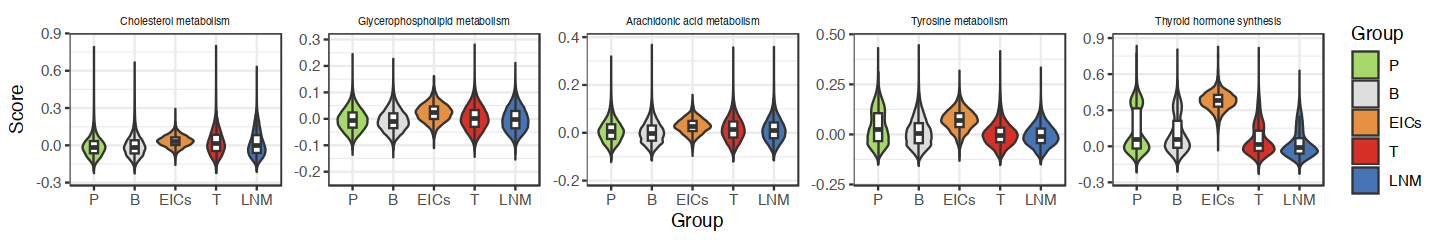

In [54]:
options(repr.plot.width=12, repr.plot.height=2)
a=select_mb_score2 %>%
    filter(Group%in%c('P','B','NB','EICs', 'T', 'LN_M')) %>%
    mutate(Group=ifelse(Group=='NB','B', Group)) %>%
    mutate(Group=ifelse(Group=='LN_M','LNM', Group)) %>%
    mutate(Group = factor(Group, levels = c('P','B', 'EICs', 'T', 'LNM'))) %>%
    #mutate(B_group = factor(B_group, levels = c('B', 'MB', 'EICs'))) %>%
    ggplot(aes(x=Group, y=Score))+
    geom_violin(aes(fill=Group))+
    geom_boxplot(width=0.2, outlier.shape = NA)+
    #scale_fill_manual(values = c('B'='#A6D96A','MB'='#FDBF6F', 'EICs'='#E69042'))+
    scale_fill_manual(values = c('P'='#A6D96A', 'B'="#dddddd", 'EICs'='#E69042', 'T'="#D73027", 'LNM'="#4575b4"))+
    facet_wrap(~Pathway, scales = 'free_y', ncol=6)+
    stat_compare_means(comparisons = list(c('MB','EICs'),c('MB','B'),c('B','EICs')), label='p.format', size=2.5)+
    scale_y_continuous(expand = c(0,0.1,0.1,0))+
    theme_bw()+ 
    theme(strip.background = element_blank(),
          strip.text = element_text(size=6, face='bold'))
a
ggsave(glue('{output_dir}/EIC差异代谢_小提琴3.pdf'), a,
       width=300, height=60, units='mm', dpi = 450, bg = 'transparent')

## 互作比较

In [135]:
library(tidyverse)
library(magrittr)
library(liana)

In [ ]:
other_srt = readRDS('../output/clean_rds/All_ann_97_new.rds')

In [128]:
set.seed(123)
sample_cells = sample(setdiff(colnames(other_srt), colnames(srt_B)), 20000)
sample_cells = c(sample_cells, colnames(srt_B))
interact_srt = subset(other_srt, cells = sample_cells)

In [129]:
interact_srt[['new_group']] = interact_srt$sub_cluster
interact_srt@meta.data[colnames(srt_B), 'new_group'] = srt_B$Type

In [136]:
show_resources()

[1] "Default"          "Consensus"        "Baccin2019"       "CellCall"        
 [5] "CellChatDB"       "Cellinker"        "CellPhoneDB"      "CellTalkDB"      
 [9] "connectomeDB2020" "EMBRACE"          "Guide2Pharma"     "HPMR"            
[13] "ICELLNET"         "iTALK"            "Kirouac2010"      "LRdb"            
[17] "Ramilowski2015"   "OmniPath"         "MouseConsensus"

In [137]:
show_methods()

[1] "connectome"      "logfc"           "natmi"           "sca"            
 [5] "cellphonedb"     "cytotalk"        "call_squidpy"    "call_cellchat"  
 [9] "call_connectome" "call_sca"        "call_italk"      "call_natmi"

In [140]:
liana_test <- liana_wrap(interact_srt,
    mehtod=c( "logfc", "sca", "cellphonedb"),
    idents_col = "new_group",
    verbose = TRUE)

Expression from the `RNA` assay will be used

Running LIANA with `new_group` as labels!

`Idents` were converted to factor

Warning message in exec(output, ...):
“2653 genes and/or 0 cells were removed as they had no counts!”
LIANA: LR summary stats calculated!

Now Running: Natmi

Now Running: Connectome

Now Running: Logfc

Now Running: Sca

Now Running: Cellphonedb



In [139]:
liana_test <- liana_test %>%
  liana_aggregate()

ERROR: Error: object 'liana_test' not found


In [ ]:
liana_test %>%
  liana_dotplot(source_groups = c("EICs", "NB"),
                target_groups = c("NK", "CD8 T", "B"),
                ntop = 20)

In [ ]:
liana_trunc <- liana_test %>%
   # only keep interactions concordant between methods
  filter(aggregate_rank <= 0.01) # note that these pvals are already corrected

heat_freq(liana_trunc)

In [ ]:
p <- chord_freq(liana_trunc,
                source_groups = c("CD8 T", "NK", "B"),
                target_groups = c("CD8 T", "NK", "B"))

In [143]:
interact_srt[['new_group2']] = interact_srt$new_group
interact_srt@meta.data[interact_srt$batch=='new', 'new_group2'] = 'MB'

In [145]:
liana_test2 <- liana_wrap(interact_srt,
    idents_col = "new_group2",
    verbose = TRUE)

Expression from the `RNA` assay will be used

Running LIANA with `new_group2` as labels!

`Idents` were converted to factor

Warning message in exec(output, ...):
“2653 genes and/or 0 cells were removed as they had no counts!”
LIANA: LR summary stats calculated!

Now Running: Natmi

Now Running: Connectome

Now Running: Logfc

Now Running: Sca

Now Running: Cellphonedb



: 